In [1]:
#####################################################################################
#########                                                              #############
#########   RF model evaluation on the testing data set for each site   ##############
########## , for each PFT and all data pooled togther across all sites   #############
#########                                                              #############
####################################################################################

In [11]:

# Import required libraries

import warnings
warnings.filterwarnings('ignore')

import glob
from datetime import datetime, timedelta 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import linregress
import scipy
import math
from math import sqrt

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import r2_score

import statsmodels.formula.api as smf
import statsmodels as sm

%matplotlib inline
sns.set_style('whitegrid')


In [12]:
# Controling the label, font, axes and legend sizes

#plt.rc('font', size=16, weight='bold') #controls default text sizesns.set_style('whitegrid')
plt.rc('font', size=16) #controls default text sizesns.set_style('whitegrid')
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels
plt.rc('legend', fontsize=18) #fontsize of the legend
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels

In [18]:
import os
os.getcwd()
os.chdir("D:/SIF_GPP_PRI_Tropomi/Linear_Regression_output/LR_Stats/LAST_testing/figures")


In [21]:
#Load your data set including the RF GPP predictions from each model
data_test = pd.read_csv('D:\SIF_GPP_PRI_Tropomi\Linear_Regression_output\LR_Stats/data_testing2.csv')

data_test = data_test.sort_values( by=["Timestamp", "GPP"])

# convert your datetime into datetime format and set it as index 
data_test['Timestamp'] = pd.to_datetime(data_test['Timestamp'], format ='%m/%d/%Y')

data_test['Timestamp'] = data_test.set_index(data_test['Timestamp'], inplace = True)
data_test = data_test.drop(columns = ['Timestamp'])

# Convert categorical variables as numeric, Biomes and Sites.
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# label_encoder object
label_encoder =LabelEncoder()
# Encode labels in column. 
#df_merge['IGBP_site']= label_encoder.fit_transform(df_merge['Biome_site'])
data_test['SiteIdx']= label_encoder.fit_transform(data_test['Site_name'])
data_test
#print(data_test.columns)

B1    B2    B3    B4    B5    B6    B7   B8    B9   B11  ...  \
Timestamp                                                              ...   
2019-01-15   867  2263   417   801  2548  2376  1492  291   358   669  ...   
2019-01-18  3382  4137  3183  3274  4112  4669  3653  731  1099  1049  ...   
2019-01-20  1074  1556   931  1014  1851  1187   700  681   843   882  ...   
2020-01-20   324  1310   139   247  1812  1374   709    6   204   346  ...   
2020-01-20   414  1608   201   383  1800  1298   690  132   155   311  ...   
...          ...   ...   ...   ...   ...   ...   ...  ...   ...   ...  ...   
2020-09-09   636  3613   306   698  3063  2049  1236  217   335   616  ...   
2020-09-09   557  2217   274   627  2275  1610   831  187   221   522  ...   
2020-09-09   636  3613   306   698  3063  2049  1236  217   335   616  ...   
2020-09-09  1151  2482   687  1062  1774  1604  1008  319   352   650  ...   
2020-09-09  1151  2482   687  1062  1774  1604  1008  319   352   650  ...   

               DoY  Site_name  Site_palette  Biome_site        GPP  GPP_RF_R  \
Timestamp                                                                      
2019-01-15  737440     IT-Lsn        IT-Lsn         OSH   0.680110  0.694672   
2019-01-18  737443     FR-Fon        FR-Fon         DBF   0.666481  0.886512   
2019-01-20  737445     IT-Lsn        IT-Lsn         OSH   0.595263  0.801318   
2020-01-20  737810     FR-Fon        FR-Fon         DBF   0.212682  0.412147   
2020-01-20  737810     FR-LGt        FR-LGt         WET   0.406877  0.713754   
...            ...        ...           ...         ...        ...       ...   
2020-09-09  738043     BE-Lon        BE-Lon         CRO   9.428313  9.722855   
2020-09-09  738043     BE-Lon        BE-Lon         CRO   9.428313  7.284163   
2020-09-09  738043     BE-Lon        BE-Lon         CRO   9.428313  9.722855   
2020-09-09  738043     FR-EM2        FR-EM2         CRO  11.388466  9.247514   
2020-09-09  738043     FR-EM2        FR-EM2         CRO  11.388466  9.247514   

            GPP_RF_SIF_R  GPP_RF_SIF_VI  GPP_RF_SIF_IGBP  SiteIdx  
Timestamp                                                          
2019-01-15      0.709128       0.765602         0.723559       32  
2019-01-18      0.927065       0.788291         0.897803       25  
2019-01-20      0.762658       0.642140         0.742234       32  
2020-01-20      0.438238       0.400508         0.409883       25  
2020-01-20      0.757602       0.935855         0.597255       27  
...                  ...            ...              ...      ...  
2020-09-09     10.383242       9.105328        10.306085        2  
2020-09-09      7.934764       7.324235         7.907982        2  
2020-09-09     10.975944      11.525650        10.951484        2  
2020-09-09      9.161085       6.417681         9.089304       24  
2020-09-09      8.183901       8.003268         8.131881       24  

[4889 rows x 30 columns]

[Text(0.5, 1.0, 'RF-SIF-R-PFT')]

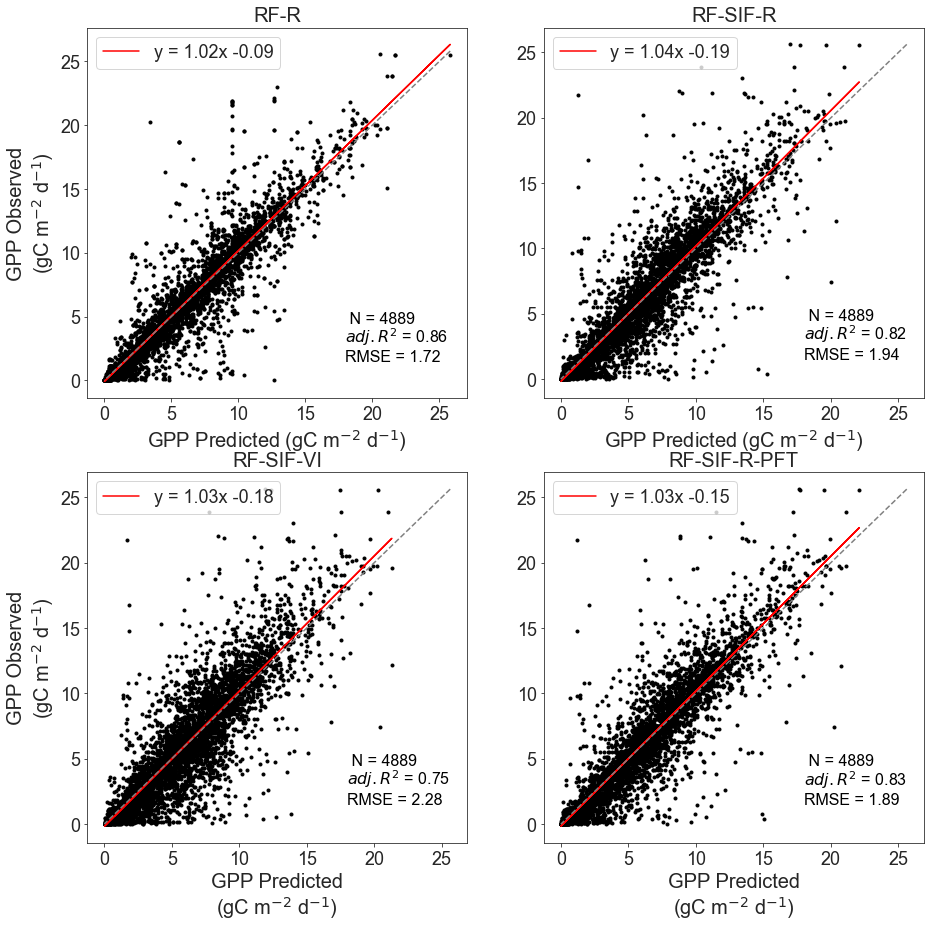

In [23]:
# Generate a plot for all sites and for each RF model

from scipy import stats
from scipy.stats import linregress
sns.set_style("ticks")
plt.rc('legend', fontsize=18) #fontsize of the legend


############################################################################################
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

axes[0,0].plot(data_test['GPP_RF_R'], data_test['GPP'],'.k')

slope, intercept, r_value, p_value, std_err= stats.linregress(data_test['GPP_RF_R'],data_test['GPP'])

line = slope*data_test['GPP_RF_R'] + (intercept)
axes[0, 0].plot(data_test['GPP_RF_R'], line, 'r', label='y = {:.2f}x {:.2f}'.format(slope,intercept))

axes[0, 0].text(18,3, '$adj.R^2$ = 0.86', color = 'k')
axes[0, 0].text(18,1.5, 'RMSE = 1.72', color = 'k')
axes[0, 0].text(18,4.5 , ' N = 4889', color = 'k')
axes[0, 0].legend()
#################################################################################################################
axes[0,1].plot(data_test['GPP_RF_SIF_R'], data_test['GPP'], '.k')

slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(data_test['GPP_RF_SIF_R'],data_test['GPP'])

line1 = slope1*data_test['GPP_RF_SIF_R'] + (intercept1)
axes[0, 1].plot(data_test['GPP_RF_SIF_R'], line1, 'r', label='y = {:.2f}x {:.2f}'.format(slope1,intercept1))

axes[0, 1].text(18,3 , '$adj.R^2$ = 0.82', color = 'k')
axes[0, 1].text(18,1.5 , 'RMSE = 1.94', color = 'k')
axes[0, 1].text(18,4.5 , ' N = 4889', color = 'k')
axes[0, 1].legend()

#################################################################################################################

axes[1,0].plot(data_test['GPP_RF_SIF_VI'], data_test['GPP'], '.k')

slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(data_test['GPP_RF_SIF_VI'],data_test['GPP'])

line2 = slope2*data_test['GPP_RF_SIF_VI'] + (intercept2)
axes[1, 0].plot(data_test['GPP_RF_SIF_VI'], line2, 'r', label='y = {:.2f}x {:.2f}'.format(slope2,intercept2))

axes[1, 0].text(18,3, '$adj.R^2$ = 0.75', color = 'k')
axes[1, 0].text(18,1.5, 'RMSE = 2.28', color = 'k')
axes[1, 0].text(18,4.5, ' N = 4889', color = 'k')
axes[1, 0].legend(loc = 'upper left')
#################################################################################################################

axes[1,1].plot(data_test['GPP_RF_SIF_IGBP'], data_test['GPP'], '.k')

slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(data_test['GPP_RF_SIF_IGBP'],data_test['GPP'])

line3 = slope3*data_test['GPP_RF_SIF_IGBP'] + (intercept3)
axes[1, 1].plot(data_test['GPP_RF_SIF_IGBP'], line3, 'r', label='y = {:.2f}x {:.2f}'.format(slope3,intercept3))

axes[1, 1].text(18,3, '$adj.R^2$ = 0.83', color = 'k')
axes[1, 1].text(18,1.5, 'RMSE = 1.89', color = 'k')
axes[1, 1].text(18,4.5, ' N = 4889', color = 'k')
axes[1, 1].legend()

#######################################################################################################################
p1 = max(max(data_test['GPP']),max(data_test['GPP_RF_R']),)
p2 = min(min(data_test['GPP']), min(data_test['GPP_RF_R']), )
p3 = max(max(data_test['GPP']),max(data_test['GPP_RF_SIF_R']),)
p4 = min(min(data_test['GPP']), min(data_test['GPP_RF_SIF_R']))
p5 = max(max(data_test['GPP']), max(data_test['GPP_RF_SIF_VI']))
p6 = min(min(data_test['GPP']),min(data_test['GPP_RF_SIF_VI']),)
p7 = max( max(data_test['GPP']),max(data_test['GPP_RF_SIF_IGBP']),)
p8 = min( min(data_test['GPP']), min(data_test['GPP_RF_SIF_IGBP']),)

##############################################################################################################
axes[0, 0].set(xlabel ='GPP Predicted (gC m$^{-2}$ d$^{-1}$)', ylabel ='GPP Observed\n(gC m$^{-2}$ d$^{-1}$)')
axes[0, 1].set(xlabel ='GPP Predicted (gC m$^{-2}$ d$^{-1}$)')
axes[1, 0].set(xlabel ='GPP Predicted\n(gC m$^{-2}$ d$^{-1}$)',ylabel ='GPP Observed\n(gC m$^{-2}$ d$^{-1}$)')
axes[1, 1].set(xlabel ='GPP Predicted\n(gC m$^{-2}$ d$^{-1}$)')

#####################################################################################################################
axes[0, 0].plot([p1, p2], [p1, p2], ls="--", c=".5")
axes[0, 1].plot([p3, p4], [p3, p4], ls="--", c=".5")
axes[1, 0].plot([p5, p6], [p5, p6], ls="--", c=".5")
axes[1,1].plot([p7, p8], [p7, p8], ls="--", c=".5")

###################################################################################################333
axes[0, 0].set(title ='RF-R')
axes[0, 1].set(title ='RF-SIF-R')
axes[1, 0].set(title ='RF-SIF-VI')
axes[1, 1].set(title ='RF-SIF-R-PFT')

#fig.savefig('RF_ALL_test3.svg',dpi = 500)

['CRO', 'DBF', 'EBF', 'ENF', 'GRA', 'MF', 'OSH', 'WET']


Text(0.5, 1.0, 'OSH, $R^2$ = 0.91, P<0.0001')

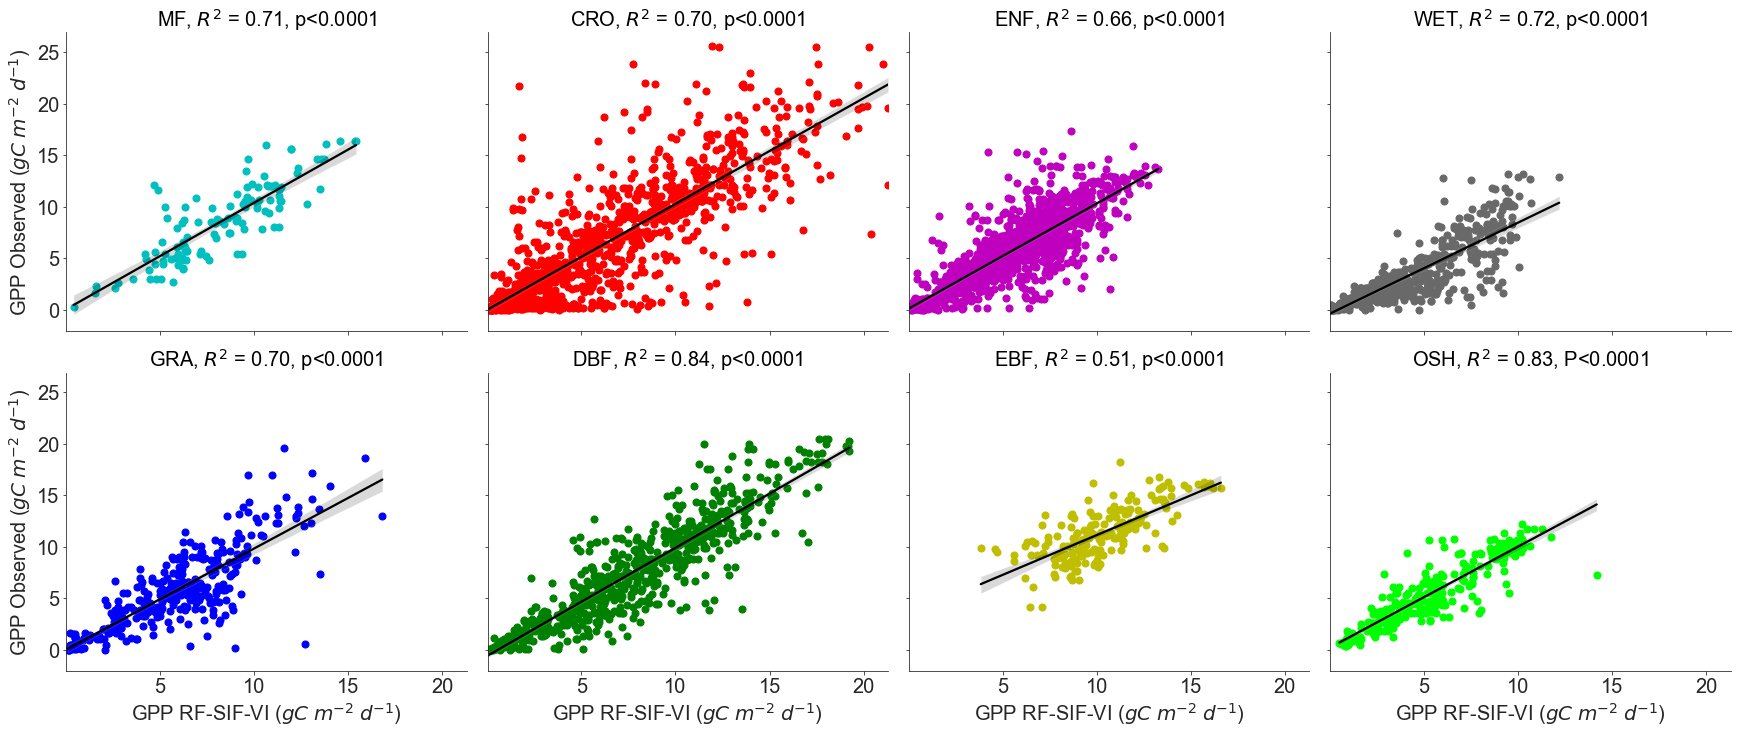

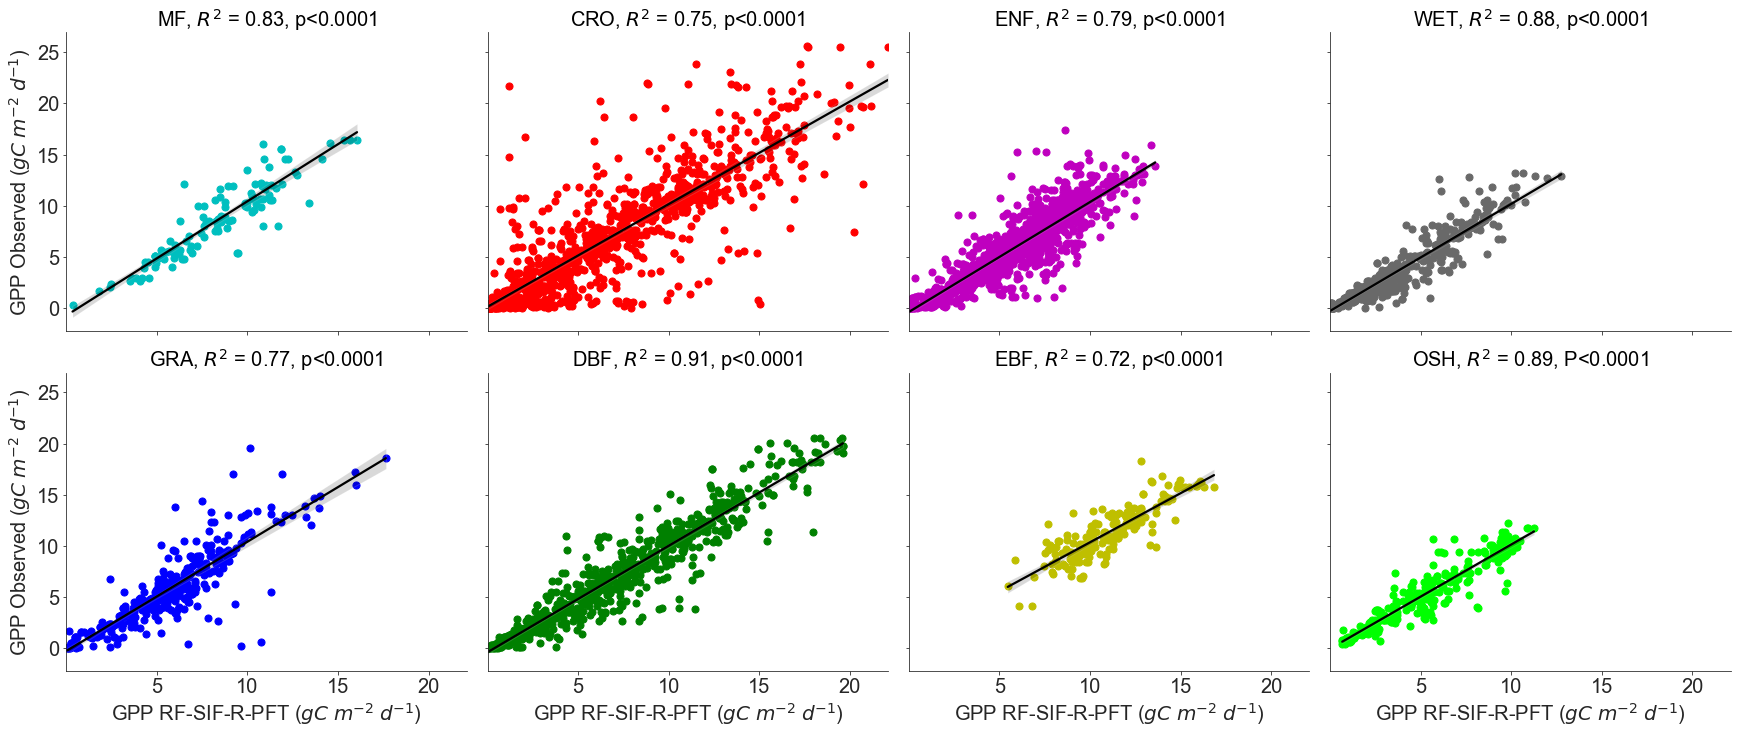

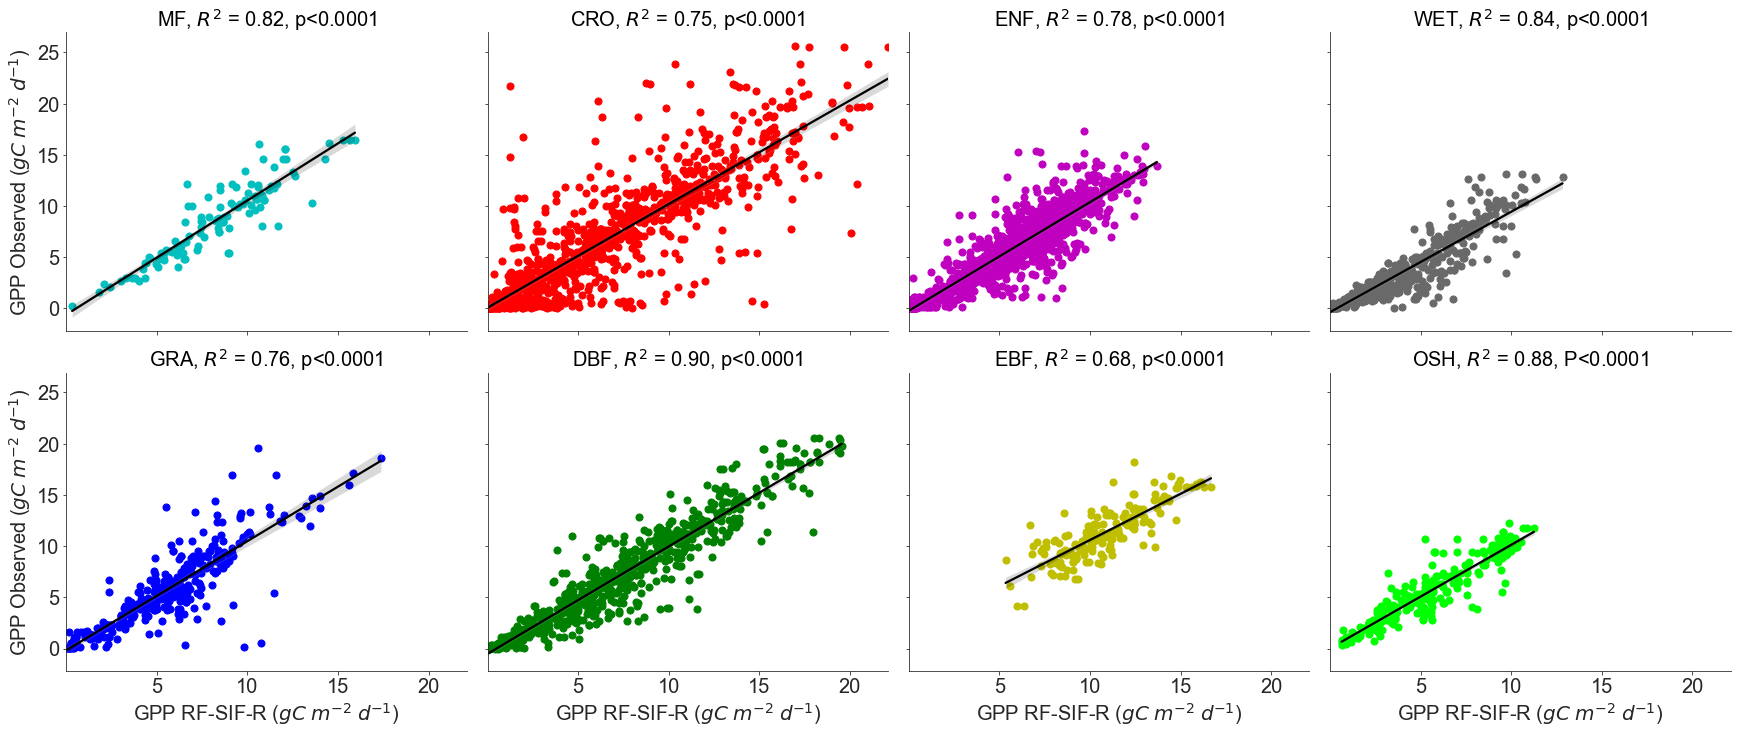

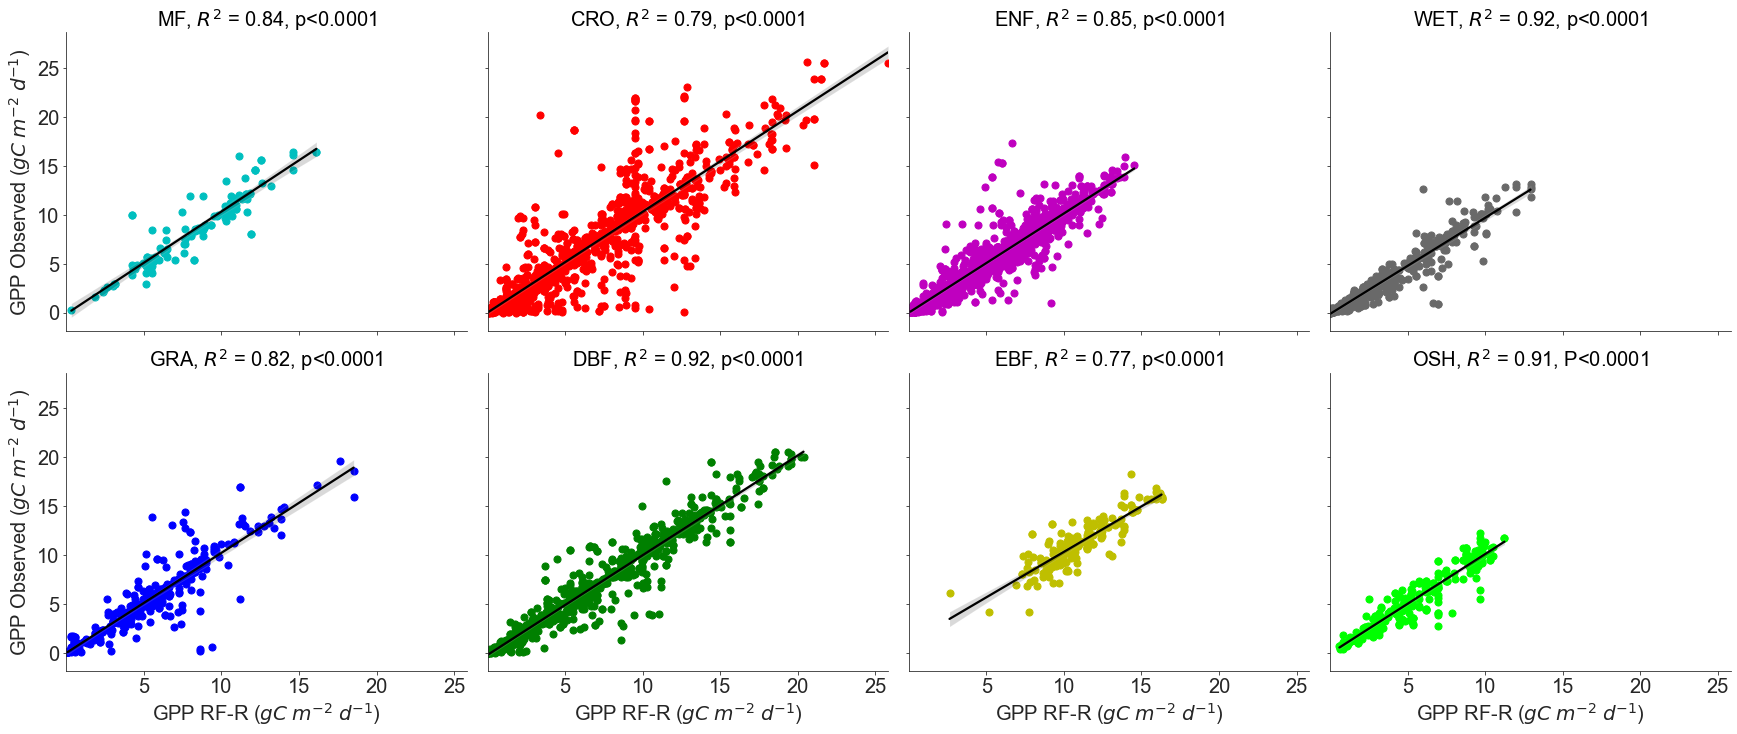

In [28]:
# Generate plots for each PFT
list_Sites = data_test["Biome_site"].unique().tolist()
# Sorting your biome list

list_Sites = sorted(list_Sites)
print(list_Sites)
data_test.sort_values('Site_name', inplace =True)
############################################################################################################
from scipy import stats
from scipy.stats import linregress
import scipy as sp

plt.rc('font', size=16) #controls default text sizesns.set_style('whitegrid')
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
sns.set_style("ticks")

# color dictionary

color_dict = dict({'MF':'c',
                  'DBF':'g',
                  'EBF': 'y',
                  'CRO': 'r',
                   'ENF': 'm',
                  'GRA': 'b',
                  'WET': 'dimgrey','OSH': 'lime',
                  })
#################################################################################################################################

Site_palette = dict({"BE-Bra":"c","BE-Lcr":"r","BE-Lon":"r","BE-Vie":"m","CH-Dav":"m","CZ-BK1":"m","CZ-Lnz":"g","CZ-Wet":"c",
                    "DE-Geb":"r","DE-Gri":"m","DE-Hai":"g","DE-HoH":"g","DE-Hzd":"m", "DE-Kli":"r","DE-RuR":"g","DE-RuS":"r","DE-RuW":"m",
                    "DE-Tha":"c", "DK-Sor":"g","FI-Hyy":"m","FI-Sii":"m","FI-Var":"m","FR-Aur":"r","FR-Bil":"m","FR-EM2":"r","FR-Fon":"g",
                    "FR-Hes":"g","FR-LGt":"c","FR-Mej":"r","GF-Guy":"y","IT-BCi":"r","IT-Cp2":"y","IT-Lsn":"r","IT-SR2":"c","IT-Tor":"b",
                     "NL-Loo":"m","SE-Deg":"m","SE-Htm":"m","SE-Htm":"m","SE-Nor":"m","SE-Svb":"m"})

##############################################################################################################################

# Generate plot between observed GPP and RF-SIF-R-PFT predicted GPP
#sns.lmplot plot data and regression model fits across a FacetGrid: combines regplot and FacetGrid data

lm = sns.lmplot(x="GPP_RF_SIF_VI", y="GPP", hue="Biome_site", col ='Biome_site', col_wrap=4,
              data=data_test, palette=color_dict, scatter_kws={"s": 50, "alpha": 1}, legend_out = False,
                 markers=["o", "o","o", "o","o","o","o","o"], height=5, aspect=1.2, line_kws={'color': 'black'})

lm.set_axis_labels("GPP RF-SIF-VI ($gC$ $m$$^{-2}$ $d$$^{-1}$)", "GPP Observed ($gC$ $m$$^{-2}$ $d$$^{-1}$)", )

lm.set_titles(col_template ='{col_name}')

ax = lm.axes

ax[0].set_title('MF, $R^2$ = 0.71, p<0.0001', color = 'k')
ax[1].set_title('CRO, $R^2$ = 0.70, p<0.0001', color = 'k')
ax[2].set_title('ENF, $R^2$ = 0.66, p<0.0001', color = 'k')
ax[3].set_title('WET, $R^2$ = 0.72, p<0.0001', color = 'k')
ax[4].set_title('GRA, $R^2$ = 0.70, p<0.0001', color = 'k')
ax[5].set_title('DBF, $R^2$ = 0.84, p<0.0001', color = 'k')
ax[6].set_title('EBF, $R^2$ = 0.51, p<0.0001', color = 'k')
ax[7].set_title('OSH, $R^2$ = 0.83, P<0.0001', color = 'k')

#lm.savefig('Lreg_biomeRF_SIF_VI.svg',dpi = 500) # uncomment this line to save your RF-SIF-VI figure into your working directory

##############################################################################################################################

# Generate plot between observed GPP and RF-SIF-R-PFT predicted GPP
#sns.lmplot plot data and regression model fits across a FacetGrid: combines regplot and FacetGrid data

lm = sns.lmplot(x="GPP_RF_SIF_IGBP", y="GPP", hue="Biome_site", col ='Biome_site', col_wrap=4,
              data=data_test, palette=color_dict, scatter_kws={"s": 50, "alpha": 1}, legend_out = False,
                 markers=["o", "o","o", "o","o","o","o","o"], height=5, aspect=1.2, line_kws={'color': 'black'})

lm.set_axis_labels("GPP RF-SIF-R-PFT ($gC$ $m$$^{-2}$ $d$$^{-1}$)", "GPP Observed ($gC$ $m$$^{-2}$ $d$$^{-1}$)", )

lm.set_titles(col_template ='{col_name}')

ax = lm.axes

ax[0].set_title('MF, $R^2$ = 0.83, p<0.0001', color = 'k')
ax[1].set_title('CRO, $R^2$ = 0.75, p<0.0001', color = 'k')
ax[2].set_title('ENF, $R^2$ = 0.79, p<0.0001', color = 'k')
ax[3].set_title('WET, $R^2$ = 0.88, p<0.0001', color = 'k')
ax[4].set_title('GRA, $R^2$ = 0.77, p<0.0001', color = 'k')
ax[5].set_title('DBF, $R^2$ = 0.91, p<0.0001', color = 'k')
ax[6].set_title('EBF, $R^2$ = 0.72, p<0.0001', color = 'k')
ax[7].set_title('OSH, $R^2$ = 0.89, P<0.0001', color = 'k')

#lm.savefig('Lreg_biomeRF_SIF_PFT.svg',dpi = 500) # uncomment this line to save your RF-SIF-R-PFT figure into your working directory


##############################################################################################################################

# Generate plot between observed GPP and RF-SIF-R predicted GPP
#sns.lmplot plot data and regression model fits across a FacetGrid: combines regplot and FacetGrid data

lm = sns.lmplot(x="GPP_RF_SIF_R", y="GPP", hue="Biome_site", col ='Biome_site', col_wrap=4,
              data=data_test, palette=color_dict, scatter_kws={"s": 50, "alpha": 1}, legend_out = False,
                 markers=["o", "o","o", "o","o","o","o","o"], height=5, aspect=1.2, line_kws={'color': 'black'})

lm.set_axis_labels("GPP RF-SIF-R ($gC$ $m$$^{-2}$ $d$$^{-1}$)", "GPP Observed ($gC$ $m$$^{-2}$ $d$$^{-1}$)", )

lm.set_titles(col_template ='{col_name}')

ax = lm.axes

ax[0].set_title('MF, $R^2$ = 0.82, p<0.0001', color = 'k')
ax[1].set_title('CRO, $R^2$ = 0.75, p<0.0001', color = 'k')
ax[2].set_title('ENF, $R^2$ = 0.78, p<0.0001', color = 'k')
ax[3].set_title('WET, $R^2$ = 0.84, p<0.0001', color = 'k')
ax[4].set_title('GRA, $R^2$ = 0.76, p<0.0001', color = 'k')
ax[5].set_title('DBF, $R^2$ = 0.90, p<0.0001', color = 'k')
ax[6].set_title('EBF, $R^2$ = 0.68, p<0.0001', color = 'k')
ax[7].set_title('OSH, $R^2$ = 0.88, P<0.0001', color = 'k')

#lm.savefig('Lreg_biomeRF_SIF_R.svg',dpi = 500) # uncomment this line to save your RF-SIF-R figure into your working directory

##############################################################################################################################

# Generate plot between observed GPP and RF-R predicted GPP
#sns.lmplot plot data and regression model fits across a FacetGrid: combines regplot and FacetGrid data

lm = sns.lmplot(x="GPP_RF_R", y="GPP", hue="Biome_site", col ='Biome_site', col_wrap=4,
              data=data_test, palette=color_dict, scatter_kws={"s": 50, "alpha": 1}, legend_out = False,
                 markers=["o", "o","o", "o","o","o","o","o"], height=5, aspect=1.2, line_kws={'color': 'black'})

lm.set_axis_labels("GPP RF-R ($gC$ $m$$^{-2}$ $d$$^{-1}$)", "GPP Observed ($gC$ $m$$^{-2}$ $d$$^{-1}$)", )

lm.set_titles(col_template ='{col_name}')

ax = lm.axes

ax[0].set_title('MF, $R^2$ = 0.84, p<0.0001', color = 'k')
ax[1].set_title('CRO, $R^2$ = 0.79, p<0.0001', color = 'k')
ax[2].set_title('ENF, $R^2$ = 0.85, p<0.0001', color = 'k')
ax[3].set_title('WET, $R^2$ = 0.92, p<0.0001', color = 'k')
ax[4].set_title('GRA, $R^2$ = 0.82, p<0.0001', color = 'k')
ax[5].set_title('DBF, $R^2$ = 0.92, p<0.0001', color = 'k')
ax[6].set_title('EBF, $R^2$ = 0.77, p<0.0001', color = 'k')
ax[7].set_title('OSH, $R^2$ = 0.91, P<0.0001', color = 'k')

#lm.savefig('Lreg_biomeRF_R.svg',dpi = 500) # uncomment this line to save your RF-R figure into your working directory

['CRO-1', 'CRO-2', 'CRO-3', 'CRO-4', 'CRO-5', 'CRO-6', 'CRO-7', 'CRO-8', 'CRO-9', 'DBF-1', 'DBF-2', 'DBF-3', 'DBF-4', 'DBF-5', 'DBF-6', 'EBF-1', 'EBF-2', 'ENF-1', 'ENF-10', 'ENF-11', 'ENF-12', 'ENF-13', 'ENF-2', 'ENF-3', 'ENF-4', 'ENF-5', 'ENF-6', 'ENF-7', 'ENF-8', 'ENF-9', 'GRA-1', 'GRA-2', 'GRA-3', 'MF-1', 'MF-2', 'OSH-1', 'WET-1', 'WET-2', 'WET-3', 'WET-4']


Text(0.5, 1.0, 'SE-Deg, $R^2$ = 0.38')

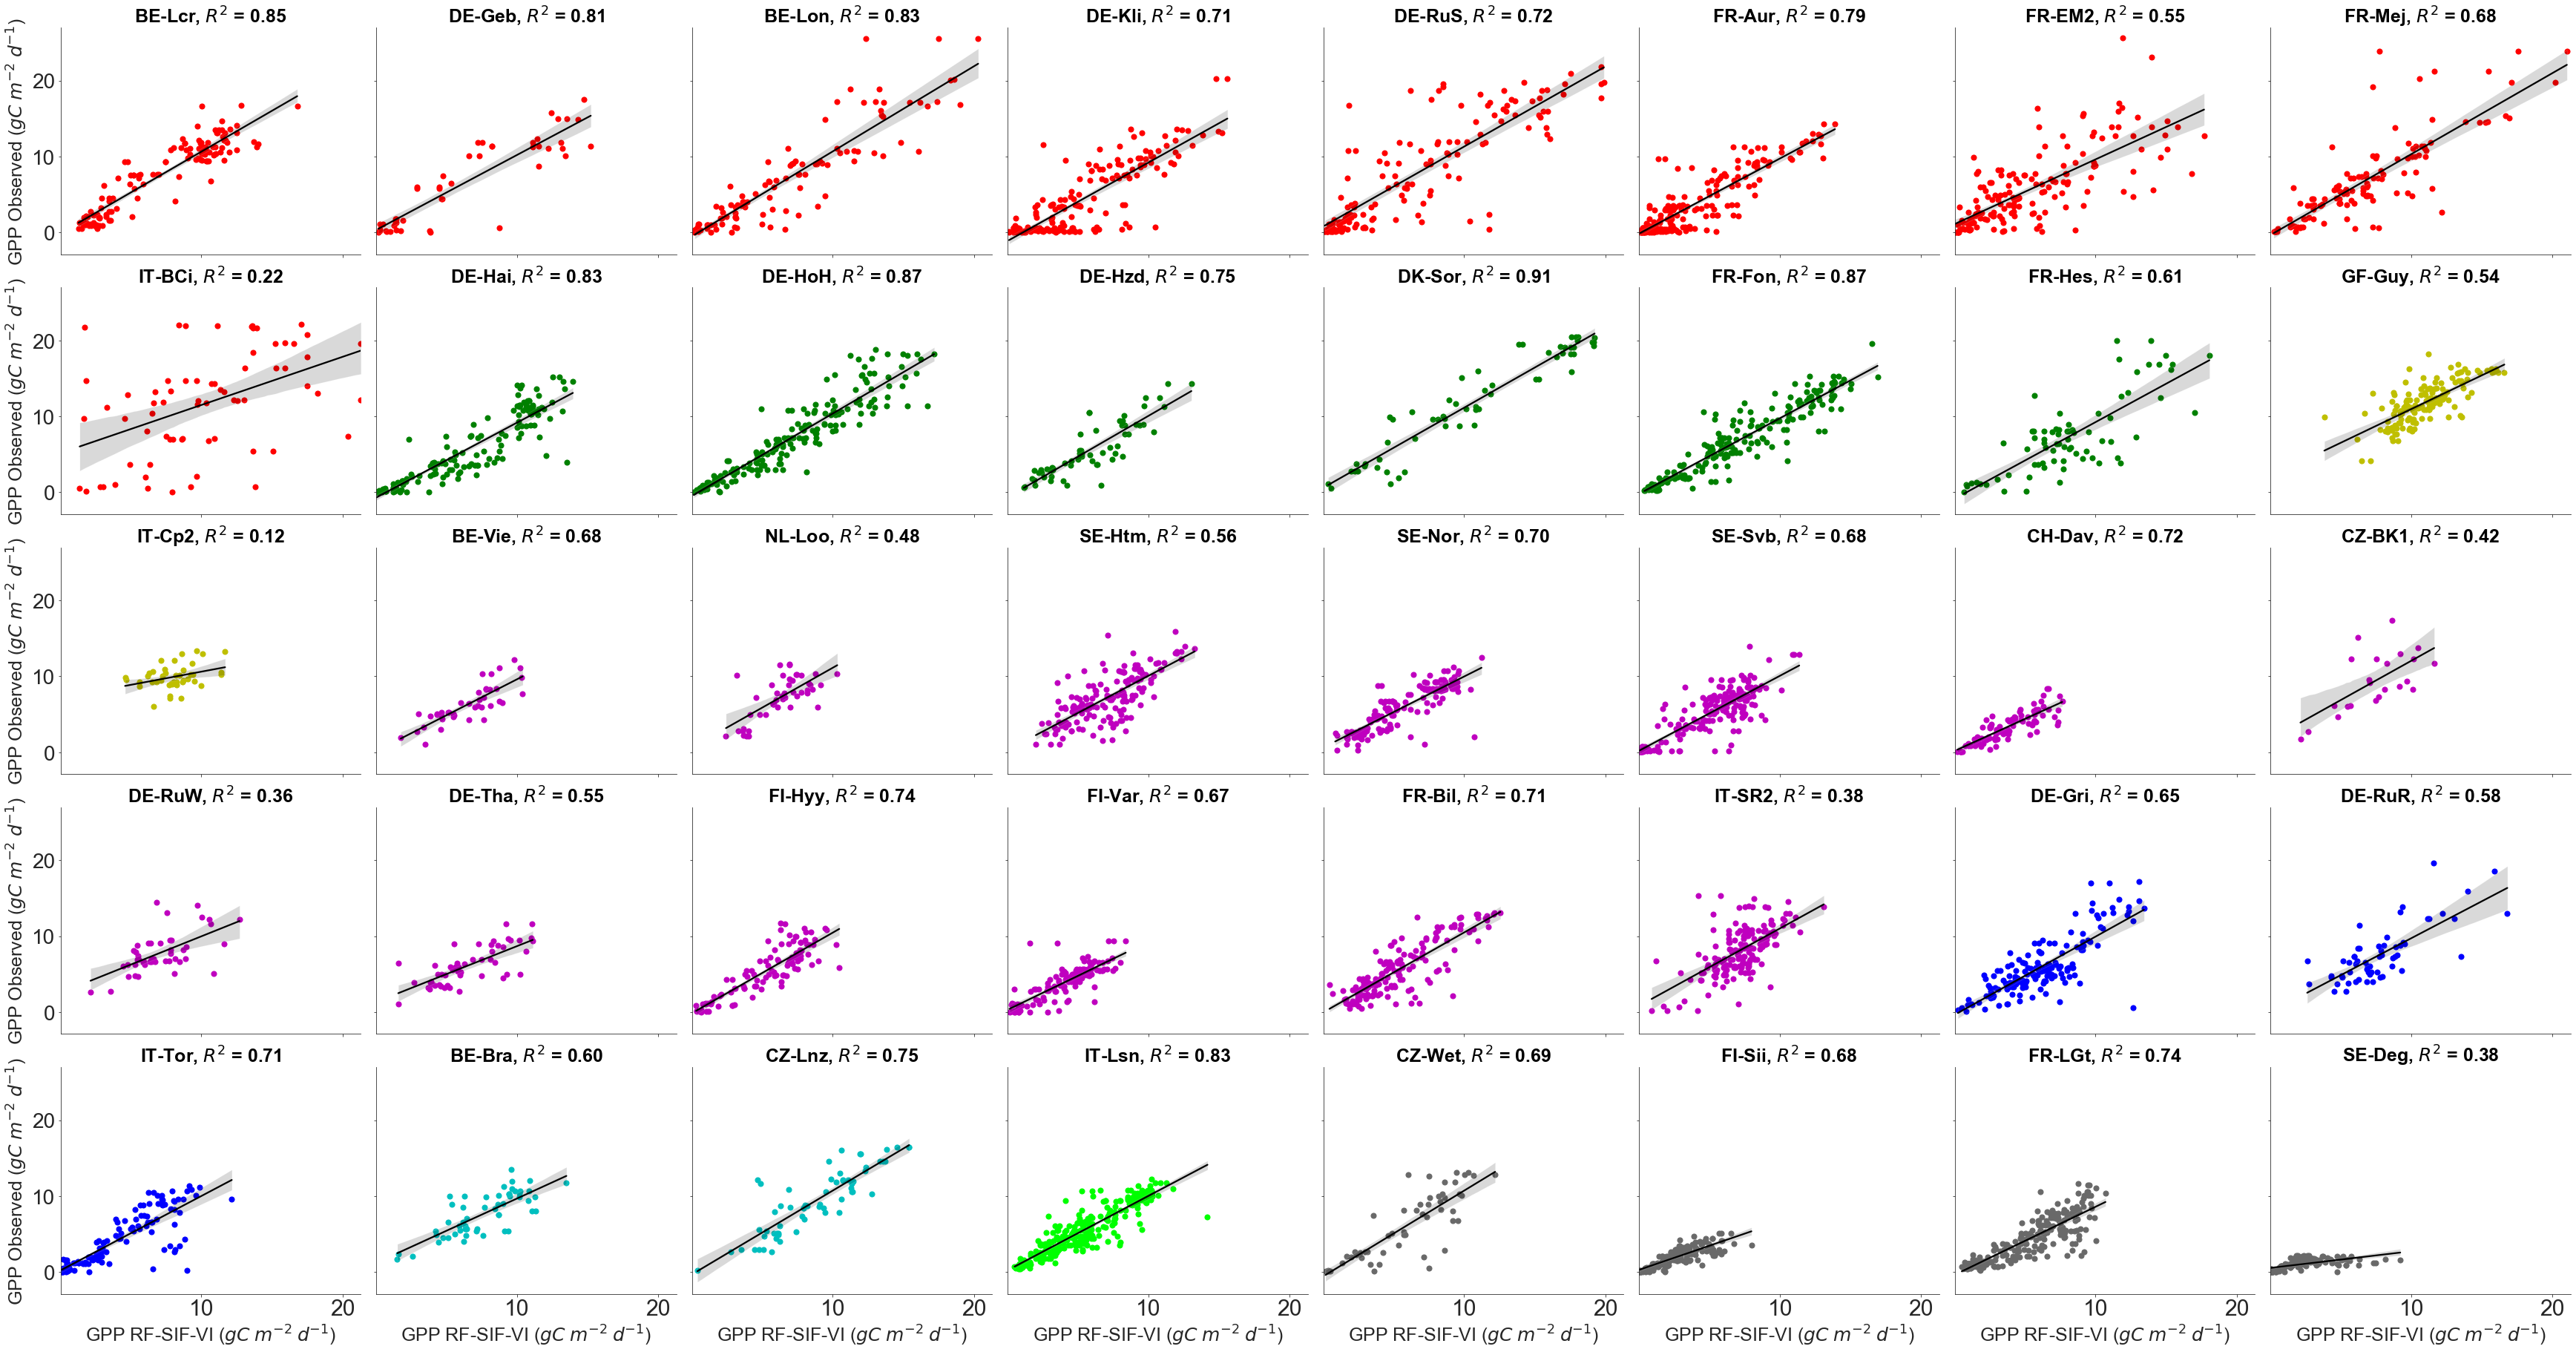

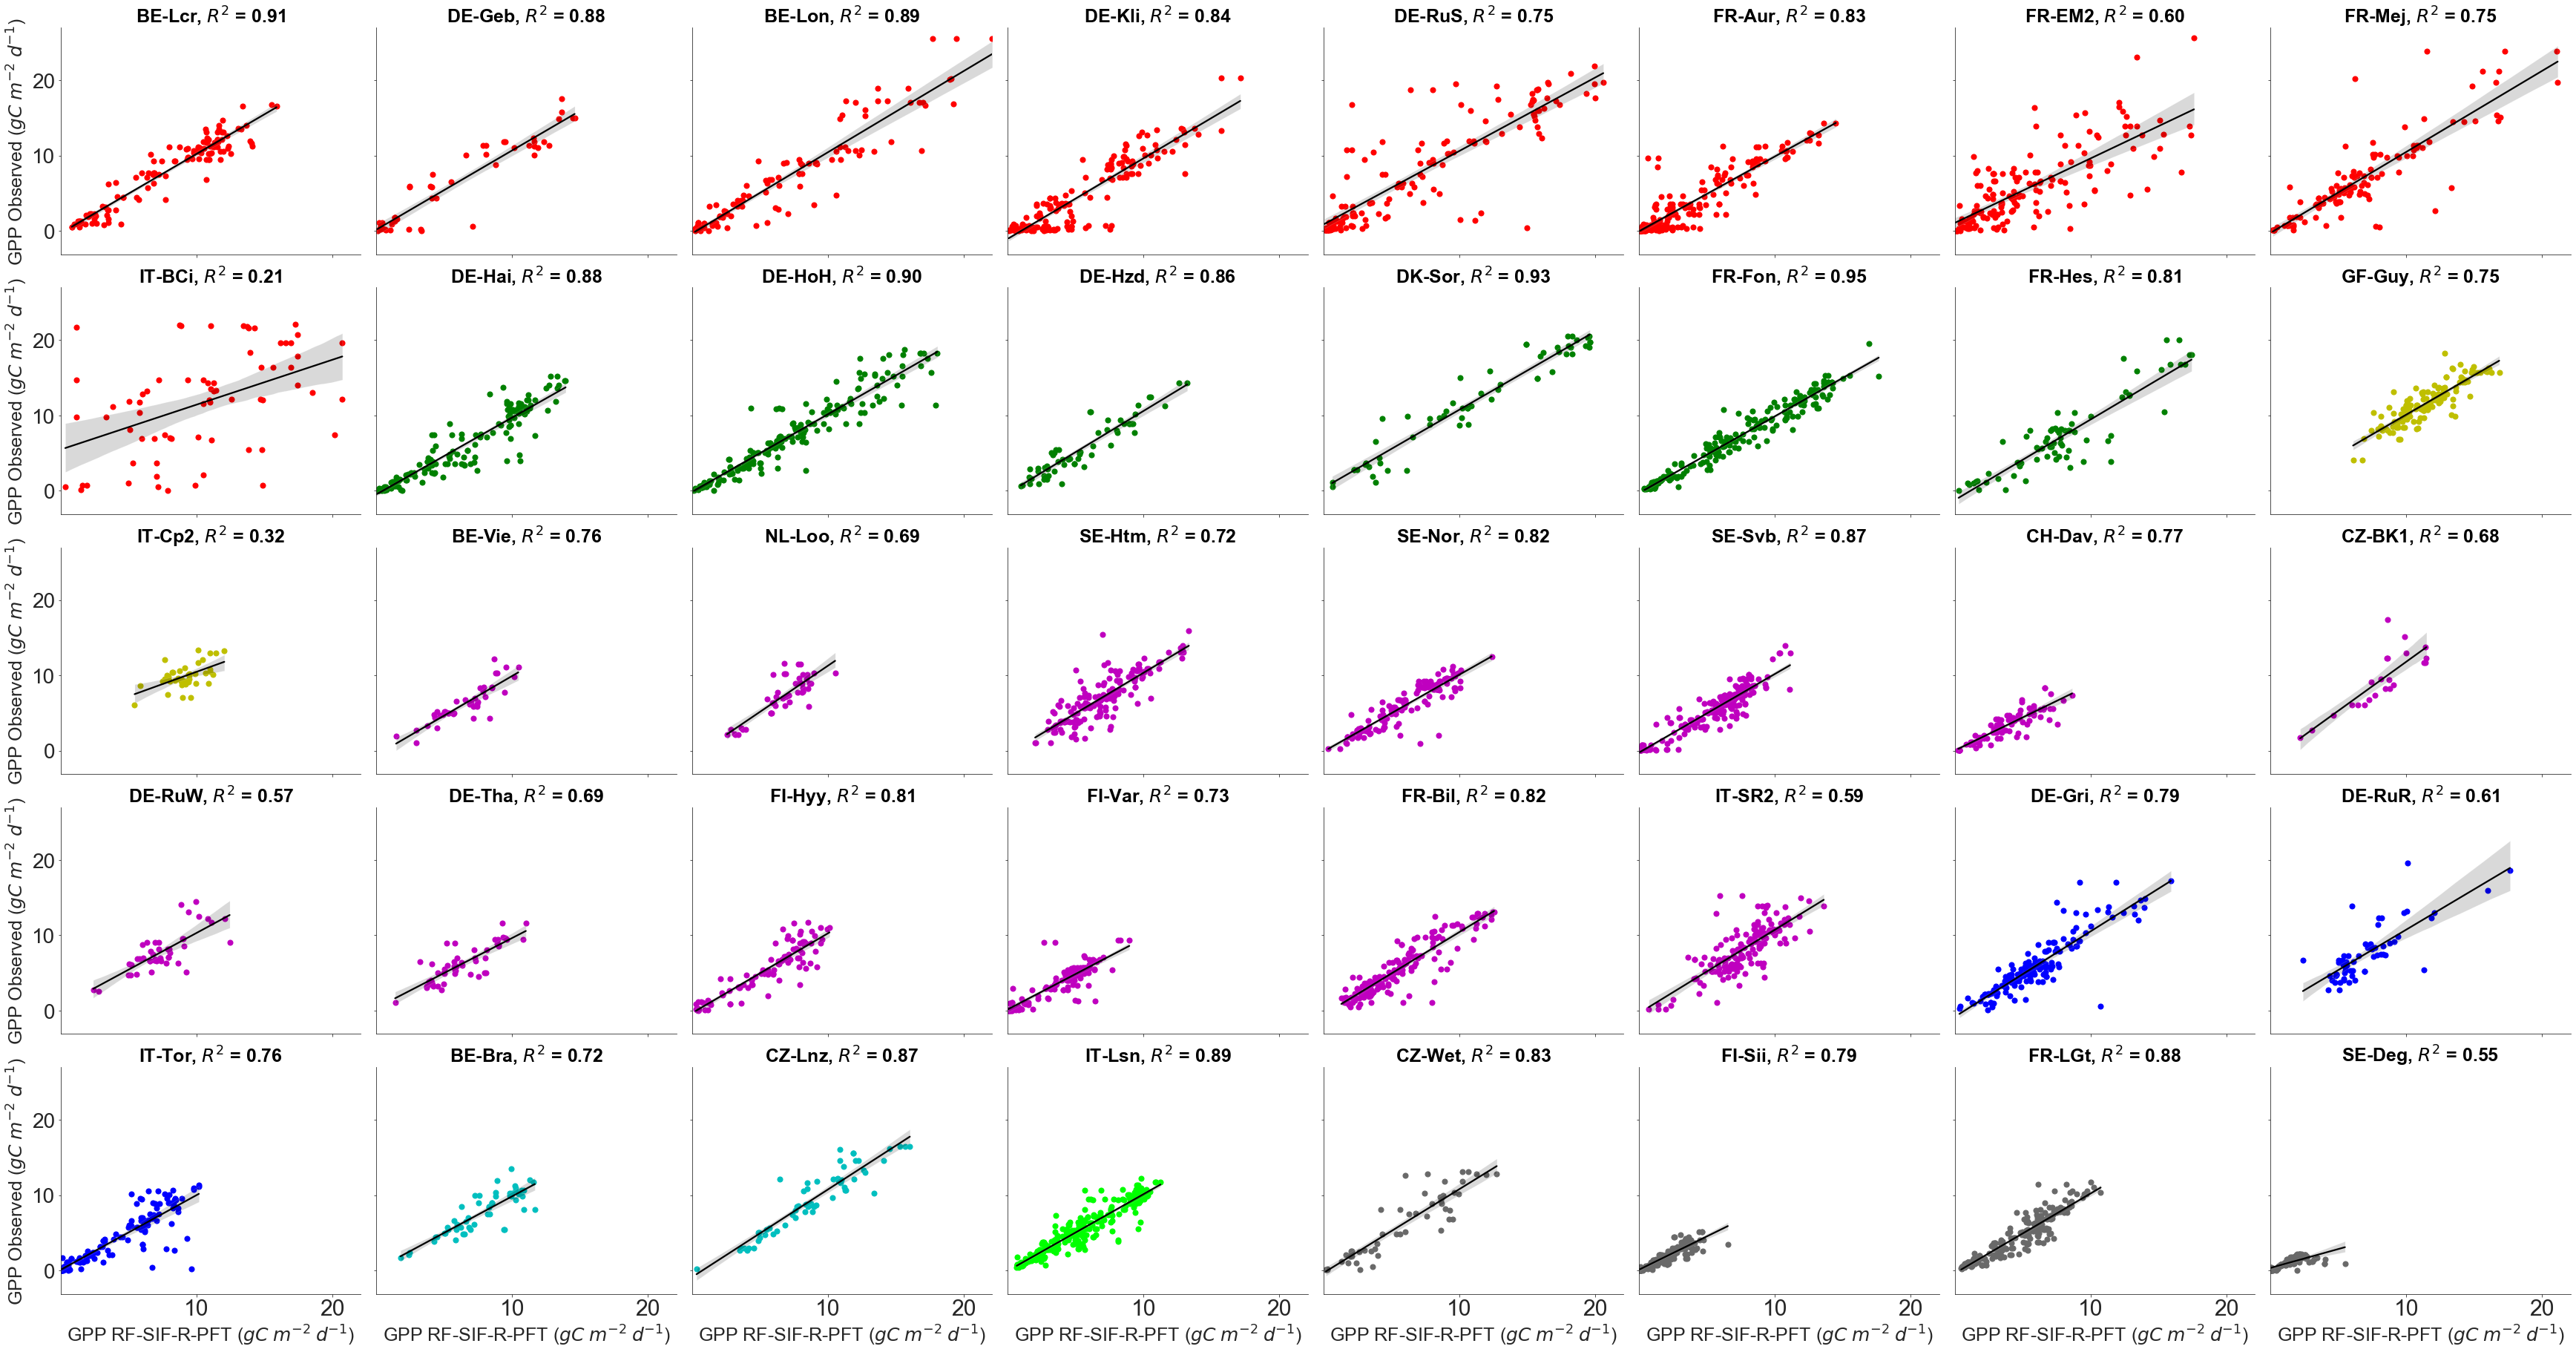

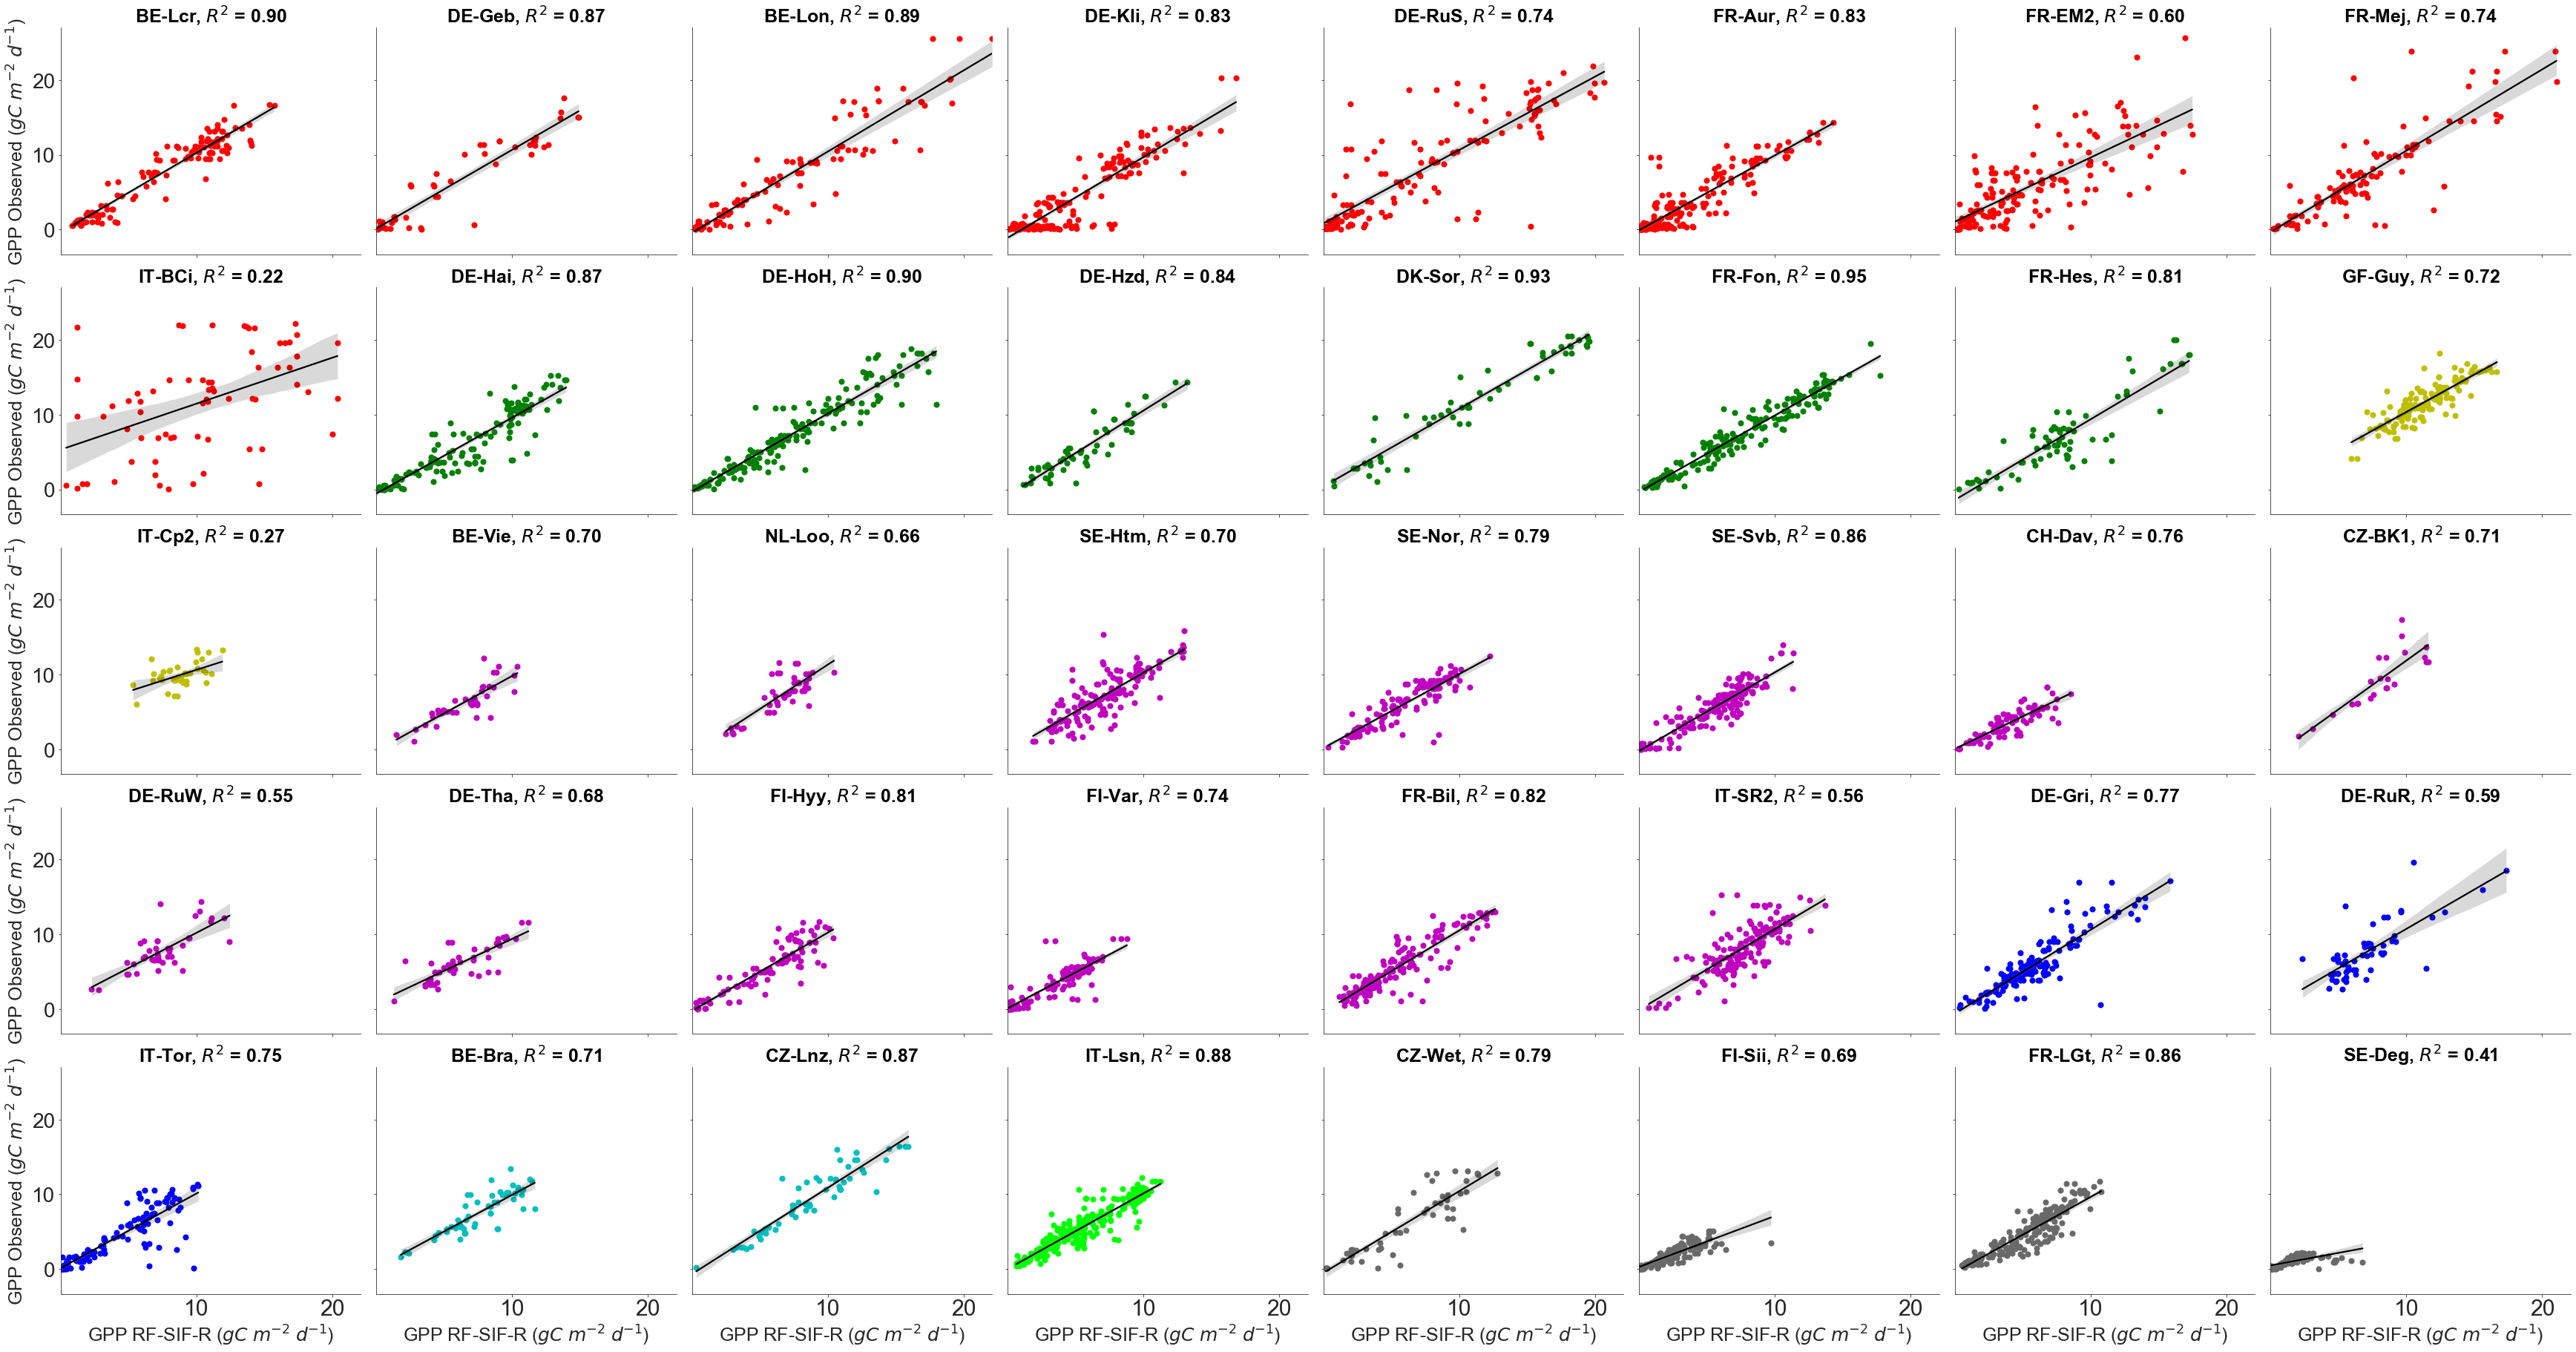

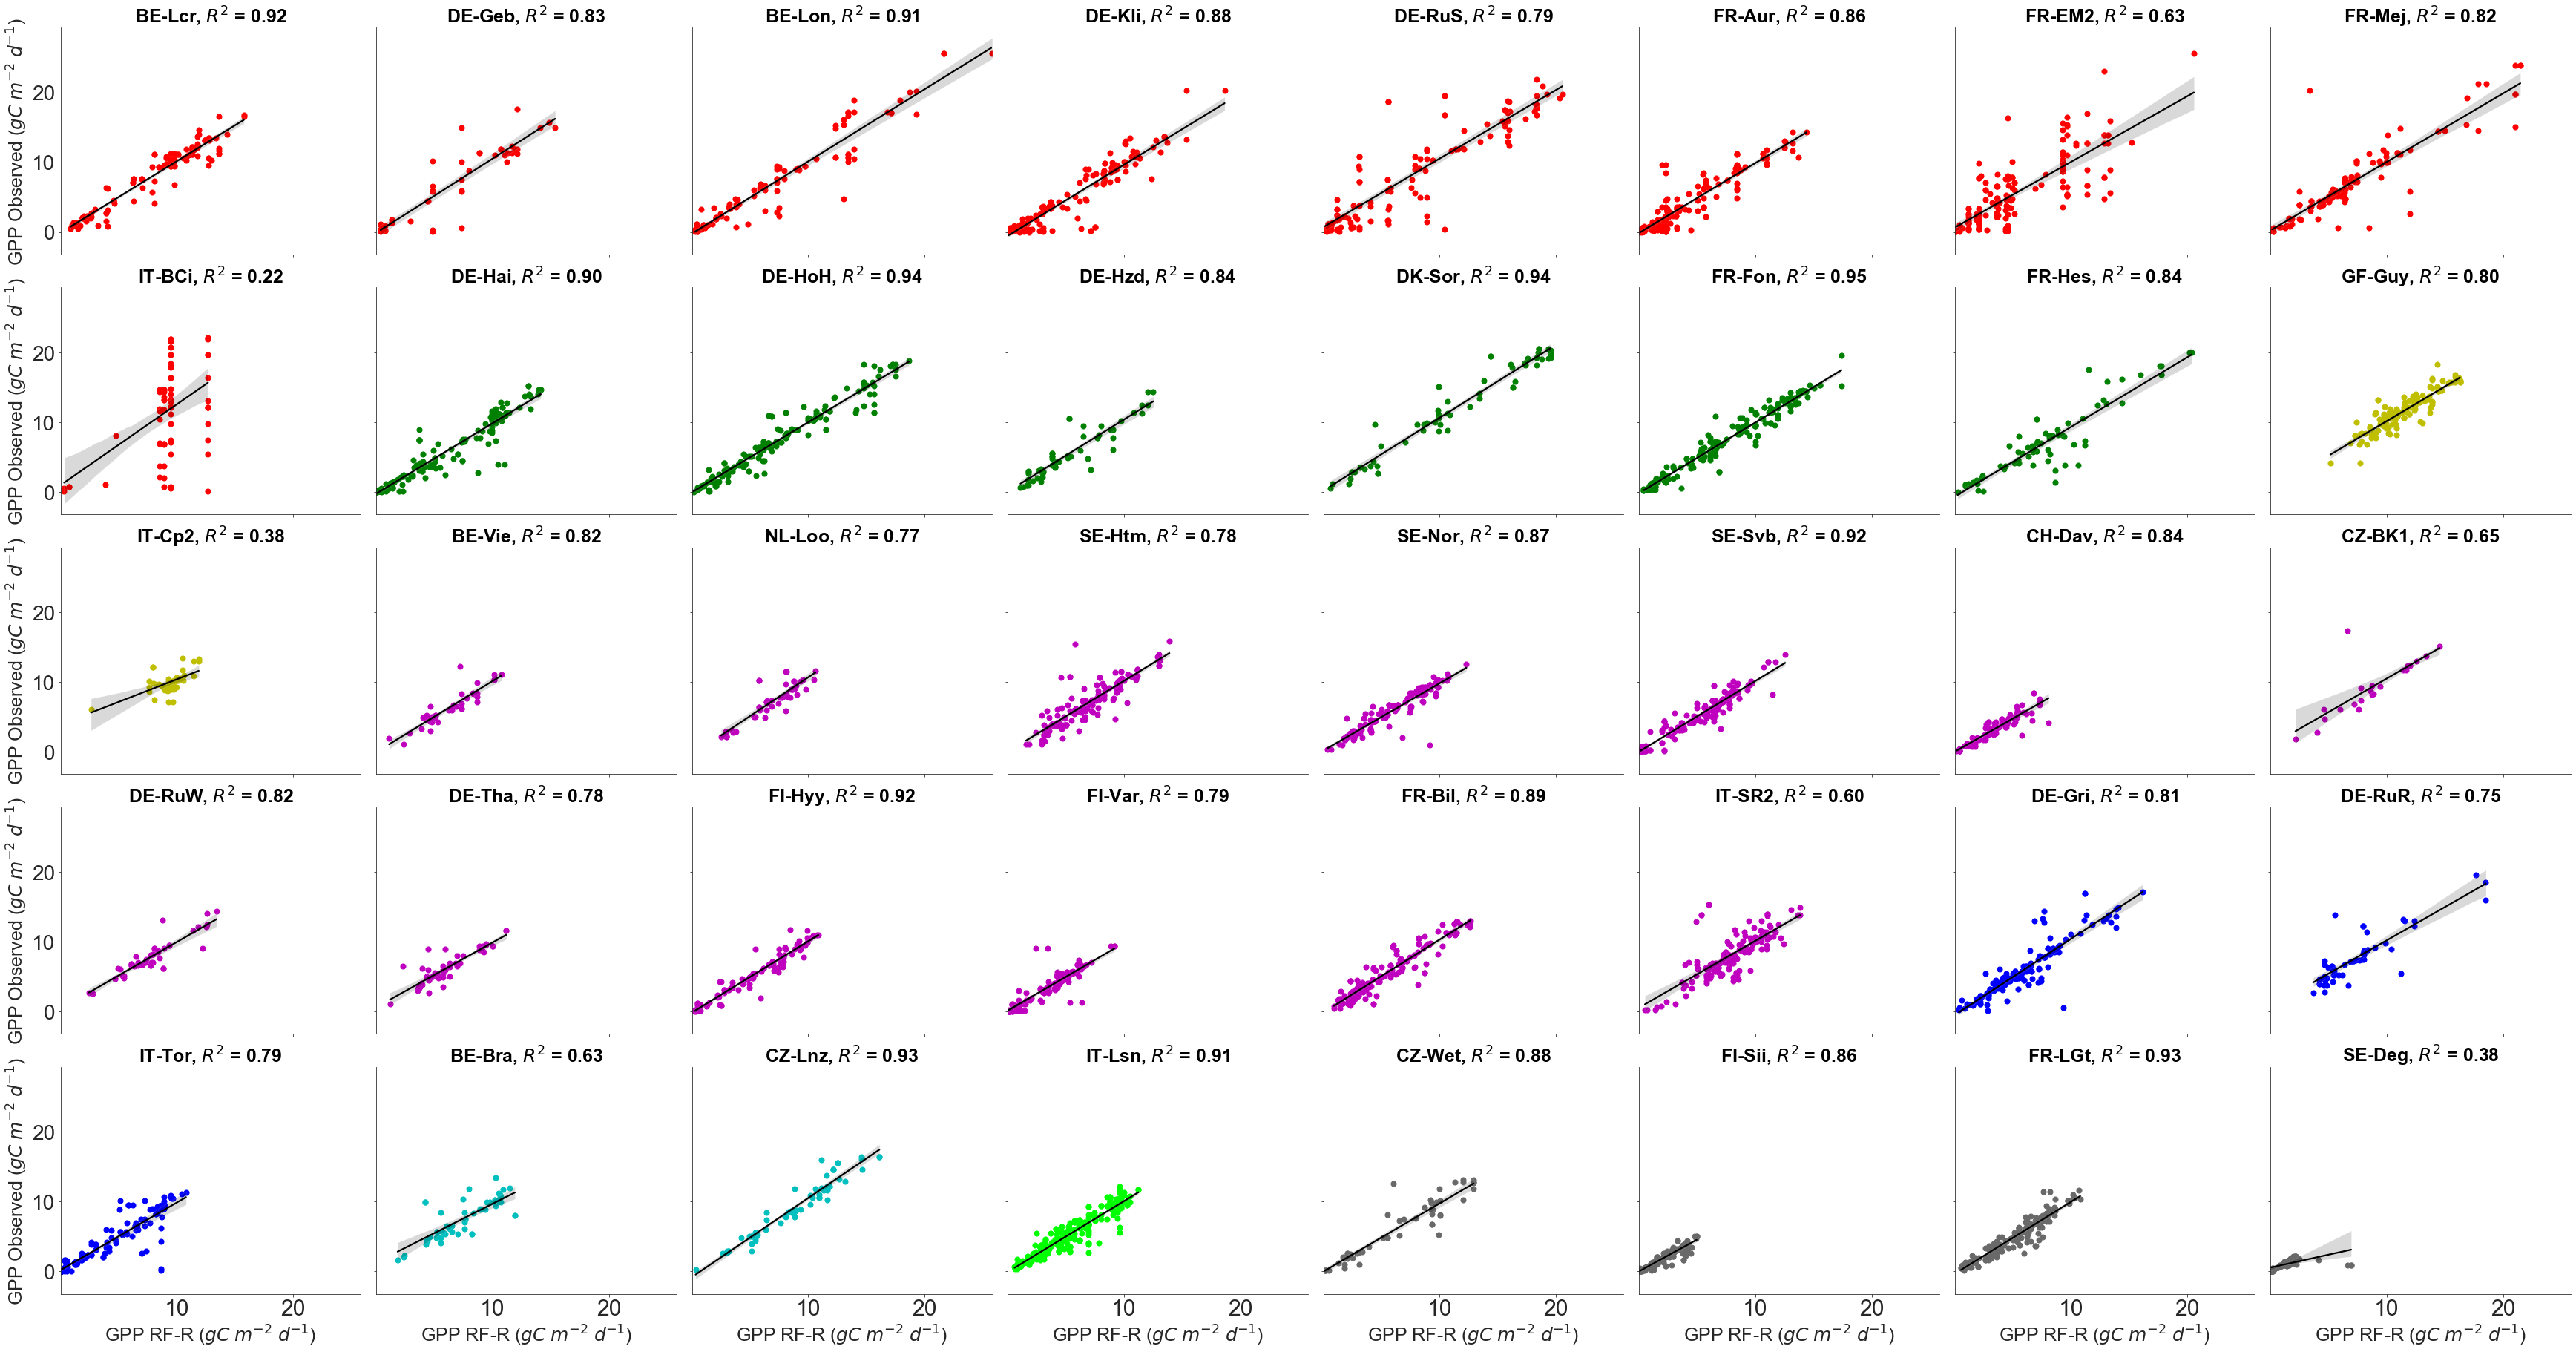

In [33]:
# Preparing the data for ploting observed GPP vs predicted GPP for each site

# Replace site name by their vegetation type name for grouping according biomes

data_test.loc[data_test["Site_palette"] == "BE-Bra", "Site_palette"] = 'MF-1'
data_test.loc[data_test["Site_palette"] == "CZ-Lnz","Site_palette"] = 'MF-2'

data_test.loc[data_test["Site_palette"] == "BE-Lcr", "Site_palette"] = 'CRO-1'
data_test.loc[data_test["Site_palette"] == "DE-Geb", "Site_palette"] = 'CRO-2'
data_test.loc[data_test["Site_palette"] == "BE-Lon", "Site_palette"] = 'CRO-3'
data_test.loc[data_test["Site_palette"] == "DE-Kli", "Site_palette"] = 'CRO-4'
data_test.loc[data_test["Site_palette"] == "DE-RuS", "Site_palette"] = 'CRO-5'
data_test.loc[data_test["Site_palette"] == "FR-Aur", "Site_palette"] = 'CRO-6'
data_test.loc[data_test["Site_palette"] == "FR-EM2", "Site_palette"] = 'CRO-7'
data_test.loc[data_test["Site_palette"] == "FR-Mej", "Site_palette"] = 'CRO-8'
data_test.loc[data_test["Site_palette"] == "IT-BCi", "Site_palette"] = 'CRO-9'

data_test.loc[data_test["Site_palette"] == "BE-Vie", "Site_palette"] = 'ENF-1'
data_test.loc[data_test["Site_palette"] == "CH-Dav", "Site_palette"] = 'ENF-2'
data_test.loc[data_test["Site_palette"] == "CZ-BK1", "Site_palette"] = 'ENF-3'
data_test.loc[data_test["Site_palette"] == "DE-RuW", "Site_palette"] = 'ENF-4'
data_test.loc[data_test["Site_palette"] == "DE-Tha", "Site_palette"] = 'ENF-5'
data_test.loc[data_test["Site_palette"] == "FI-Hyy", "Site_palette"] = 'ENF-6'
data_test.loc[data_test["Site_palette"] == "FI-Var", "Site_palette"] = 'ENF-7'
data_test.loc[data_test["Site_palette"] == "FR-Bil", "Site_palette"] = 'ENF-8'
data_test.loc[data_test["Site_palette"] == "IT-SR2", "Site_palette"] = 'ENF-9'
data_test.loc[data_test["Site_palette"] == "NL-Loo", "Site_palette"] = 'ENF-10'
data_test.loc[data_test["Site_palette"] == "SE-Htm", "Site_palette"] = 'ENF-11'
data_test.loc[data_test["Site_palette"] == "SE-Nor", "Site_palette"] = 'ENF-12'
data_test.loc[data_test["Site_palette"] == "SE-Svb", "Site_palette"] = 'ENF-13'

data_test.loc[data_test["Site_palette"] == "DE-Hai", "Site_palette"] = 'DBF-1'
data_test.loc[data_test["Site_palette"] == "DE-HoH", "Site_palette"] = 'DBF-2'
data_test.loc[data_test["Site_palette"] == "DE-Hzd", "Site_palette"] = 'DBF-3'
data_test.loc[data_test["Site_palette"] == "DK-Sor", "Site_palette"] = 'DBF-4'
data_test.loc[data_test["Site_palette"] == "FR-Fon", "Site_palette"] = 'DBF-5'
data_test.loc[data_test["Site_palette"] == "FR-Hes", "Site_palette"] = 'DBF-6'

data_test.loc[data_test["Site_palette"] == "GF-Guy", "Site_palette"] = 'EBF-1'
data_test.loc[data_test["Site_palette"] == "IT-Cp2", "Site_palette"] = 'EBF-2'

data_test.loc[data_test["Site_palette"] == "DE-Gri", "Site_palette"] = 'GRA-1'
data_test.loc[data_test["Site_palette"] == "DE-RuR", "Site_palette"] = 'GRA-2'
data_test.loc[data_test["Site_palette"] == "IT-Tor", "Site_palette"] = 'GRA-3'

data_test.loc[data_test["Site_palette"] == "CZ-Wet", "Site_palette"] = 'WET-1'
data_test.loc[data_test["Site_palette"] == "FI-Sii", "Site_palette"] = 'WET-2'
data_test.loc[data_test["Site_palette"] == "FR-LGt","Site_palette"] = 'WET-3'
data_test.loc[data_test["Site_palette"] == "SE-Deg", "Site_palette"] = 'WET-4'

data_test.loc[data_test["Site_palette"] == "IT-Lsn", "Site_palette"] = 'OSH-1'

############################################################################################
list_Sites = data_test["Site_palette"].unique().tolist()
# Sorting your biome list

list_Sites = sorted(list_Sites)
print(list_Sites)
data_test.sort_values('Site_palette', inplace =True)

##############################################################################################
# Site specific SIF-GPP Relation using sns.lmplot
#plt.rc('axes', titlesize=30) #fontsize of the title
sns.set_style("ticks")

plt.rc('axes', titlesize=50) #fontsize of the title
plt.rc('xtick', labelsize=30) #fontsize of the x tick labels
plt.rc('ytick', labelsize=28) #fontsize of the y tick labels
plt.rc('legend', fontsize=30) #fontsize of the legend
plt.rc('axes', titlesize=25) #fontsize of the title
plt.rc('axes', labelsize=25) #fontsize of the x and y labels


################################################################################################################################################
                    

Site_palette2 = dict({"CRO-1":"r","CRO-2":"r","CRO-3":"r","CRO-4":"r","CRO-5":"r","CRO-6":"r","CRO-7":"r","CRO-8":"r","CRO-9":"r",
                      "DBF-1":"g","DBF-2":"g","DBF-3":"g", "DBF-4":"g","DBF-5":"g","DBF-6":"g","EBF-1":"y","EBF-2":"y",
                      "ENF-1":"m","ENF-10":"m","ENF-11":"m","ENF-12":"m","ENF-13":"m","ENF-2":"m","ENF-3":"m","ENF-4":"m",
                      "ENF-5":"m","ENF-6":"m","ENF-7":"m","ENF-8":"m","ENF-9":"m","GRA-1":"b","GRA-2":"b","GRA-3":"b", "MF-1":"c","MF-2":"c",
                      "OSH-1":"lime", "WET-1":"dimgrey","WET-2":"dimgrey","WET-3":"dimgrey","WET-4":"dimgrey"
                      })

##############################################################################################################################

# Observed GPP vs RF-SIF-VI predicted GPP for each site

lm = sns.lmplot(x="GPP_RF_SIF_VI", y="GPP", hue="Site_palette",col ='Site_palette',col_wrap=8,
              data=data_test, scatter_kws={"s": 50, "alpha": 1},legend_out = False
                , height=5, aspect=1.2, palette = Site_palette2, line_kws={'color': 'black'})

lm.set_axis_labels("GPP RF-SIF-VI ($gC$ $m$$^{-2}$ $d$$^{-1}$)", "GPP Observed ($gC$ $m$$^{-2}$ $d$$^{-1}$)", )

lm.set_titles(col_template ='{col_name}')

ax = lm.axes

ax[0].set_title('BE-Lcr, $R^2$ = 0.85', color = 'k',weight ='bold')
ax[1].set_title('DE-Geb, $R^2$ = 0.81', color = 'k',weight ='bold' )
ax[2].set_title('BE-Lon, $R^2$ = 0.83', color = 'k',weight ='bold')
ax[3].set_title('DE-Kli, $R^2$ = 0.71', color = 'k', weight ='bold')
ax[4].set_title('DE-RuS, $R^2$ = 0.72', color = 'k', weight ='bold')
ax[5].set_title('FR-Aur, $R^2$ = 0.79', color = 'k', weight ='bold')
ax[6].set_title('FR-EM2, $R^2$ = 0.55', color = 'k',weight ='bold' )
ax[7].set_title('FR-Mej, $R^2$ = 0.68', color = 'k', weight ='bold')
ax[8].set_title('IT-BCi, $R^2$ = 0.22', color = 'k', weight ='bold')

ax[9].set_title('DE-Hai, $R^2$ = 0.83', color = 'k',weight ='bold')
ax[10].set_title('DE-HoH, $R^2$ = 0.87', color = 'k',weight ='bold')
ax[11].set_title('DE-Hzd, $R^2$ = 0.75', color = 'k', weight ='bold')
ax[12].set_title('DK-Sor, $R^2$ = 0.91', color = 'k',weight ='bold')
ax[13].set_title('FR-Fon, $R^2$ = 0.87', color = 'k',weight ='bold')
ax[14].set_title('FR-Hes, $R^2$ = 0.61', color = 'k',weight ='bold')

ax[15].set_title('GF-Guy, $R^2$ = 0.54', color = 'k', weight ='bold')
ax[16].set_title('IT-Cp2, $R^2$ = 0.12', color = 'k', weight ='bold')

ax[17].set_title('BE-Vie, $R^2$ = 0.68', color = 'k',weight ='bold')
ax[18].set_title('NL-Loo, $R^2$ = 0.48', color = 'k',weight ='bold')
ax[19].set_title('SE-Htm, $R^2$ = 0.56', color = 'k', weight ='bold')
ax[20].set_title('SE-Nor, $R^2$ = 0.70', color = 'k', weight ='bold')
ax[21].set_title('SE-Svb, $R^2$ = 0.68', color = 'k', weight ='bold')
ax[22].set_title('CH-Dav, $R^2$ = 0.72', color = 'k', weight ='bold')
ax[23].set_title('CZ-BK1, $R^2$ = 0.42', color = 'k', weight ='bold')
ax[24].set_title('DE-RuW, $R^2$ = 0.36', color = 'k',weight ='bold' )
ax[25].set_title('DE-Tha, $R^2$ = 0.55', color = 'k',weight ='bold')
ax[26].set_title('FI-Hyy, $R^2$ = 0.74', color = 'k',weight ='bold')
ax[27].set_title('FI-Var, $R^2$ = 0.67', color = 'k', weight ='bold')
ax[28].set_title('FR-Bil, $R^2$ = 0.71', color = 'k', weight ='bold')
ax[29].set_title('IT-SR2, $R^2$ = 0.38', color = 'k',weight ='bold')

ax[30].set_title('DE-Gri, $R^2$ = 0.65', color = 'k',weight ='bold')
ax[31].set_title('DE-RuR, $R^2$ = 0.58', color = 'k', weight ='bold')
ax[32].set_title('IT-Tor, $R^2$ = 0.71', color = 'k',weight ='bold')

ax[33].set_title('BE-Bra, $R^2$ = 0.60', color = 'k',weight ='bold' )
ax[34].set_title('CZ-Lnz, $R^2$ = 0.75', color = 'k', weight ='bold')

ax[35].set_title('IT-Lsn, $R^2$ = 0.83', color = 'k',weight ='bold' )

ax[36].set_title('CZ-Wet, $R^2$ = 0.69', color = 'k', weight ='bold')
ax[37].set_title('FI-Sii, $R^2$ = 0.68', color = 'k', weight ='bold')
ax[38].set_title('FR-LGt, $R^2$ = 0.74', color = 'k',weight ='bold')
ax[39].set_title('SE-Deg, $R^2$ = 0.38', color = 'k', weight ='bold')

# Save your figure
#lm.savefig('Lreg_Sites_RF_SIF_VI.svg',dpi = 500) # uncomment this line to save your RF-SIF-VI figure for each site
#######################################################################################################################################

# Observed GPP vs RF-SIF-R-PFT predicted GPP for each site

lm = sns.lmplot(x="GPP_RF_SIF_IGBP", y="GPP", hue="Site_palette",col ='Site_palette',col_wrap=8,
              data=data_test, scatter_kws={"s": 50, "alpha": 1},legend_out = False
                , height=5, aspect=1.2, palette = Site_palette2, line_kws={'color': 'black'})

lm.set_axis_labels("GPP RF-SIF-R-PFT ($gC$ $m$$^{-2}$ $d$$^{-1}$)", "GPP Observed ($gC$ $m$$^{-2}$ $d$$^{-1}$)", )

lm.set_titles(col_template ='{col_name}')
ax = lm.axes

ax[0].set_title('BE-Lcr, $R^2$ = 0.91', color = 'k',weight ='bold')
ax[1].set_title('DE-Geb, $R^2$ = 0.88', color = 'k',weight ='bold' )
ax[2].set_title('BE-Lon, $R^2$ = 0.89', color = 'k',weight ='bold')
ax[3].set_title('DE-Kli, $R^2$ = 0.84', color = 'k', weight ='bold')
ax[4].set_title('DE-RuS, $R^2$ = 0.75', color = 'k', weight ='bold')
ax[5].set_title('FR-Aur, $R^2$ = 0.83', color = 'k', weight ='bold')
ax[6].set_title('FR-EM2, $R^2$ = 0.60', color = 'k',weight ='bold' )
ax[7].set_title('FR-Mej, $R^2$ = 0.75', color = 'k', weight ='bold')
ax[8].set_title('IT-BCi, $R^2$ = 0.21', color = 'k', weight ='bold')

ax[9].set_title('DE-Hai, $R^2$ = 0.88', color = 'k',weight ='bold')
ax[10].set_title('DE-HoH, $R^2$ = 0.90', color = 'k',weight ='bold')
ax[11].set_title('DE-Hzd, $R^2$ = 0.86', color = 'k', weight ='bold')
ax[12].set_title('DK-Sor, $R^2$ = 0.93', color = 'k',weight ='bold')
ax[13].set_title('FR-Fon, $R^2$ = 0.95', color = 'k',weight ='bold')
ax[14].set_title('FR-Hes, $R^2$ = 0.81', color = 'k',weight ='bold')

ax[15].set_title('GF-Guy, $R^2$ = 0.75', color = 'k', weight ='bold')
ax[16].set_title('IT-Cp2, $R^2$ = 0.32', color = 'k', weight ='bold')

ax[17].set_title('BE-Vie, $R^2$ = 0.76', color = 'k',weight ='bold')
ax[18].set_title('NL-Loo, $R^2$ = 0.69', color = 'k',weight ='bold')
ax[19].set_title('SE-Htm, $R^2$ = 0.72', color = 'k', weight ='bold')
ax[20].set_title('SE-Nor, $R^2$ = 0.82', color = 'k', weight ='bold')
ax[21].set_title('SE-Svb, $R^2$ = 0.87', color = 'k', weight ='bold')
ax[22].set_title('CH-Dav, $R^2$ = 0.77', color = 'k', weight ='bold')
ax[23].set_title('CZ-BK1, $R^2$ = 0.68', color = 'k', weight ='bold')
ax[24].set_title('DE-RuW, $R^2$ = 0.57', color = 'k',weight ='bold' )
ax[25].set_title('DE-Tha, $R^2$ = 0.69', color = 'k',weight ='bold')
ax[26].set_title('FI-Hyy, $R^2$ = 0.81', color = 'k',weight ='bold')
ax[27].set_title('FI-Var, $R^2$ = 0.73', color = 'k', weight ='bold')
ax[28].set_title('FR-Bil, $R^2$ = 0.82', color = 'k', weight ='bold')
ax[29].set_title('IT-SR2, $R^2$ = 0.59', color = 'k',weight ='bold')

ax[30].set_title('DE-Gri, $R^2$ = 0.79', color = 'k',weight ='bold')
ax[31].set_title('DE-RuR, $R^2$ = 0.61', color = 'k', weight ='bold')
ax[32].set_title('IT-Tor, $R^2$ = 0.76', color = 'k',weight ='bold')

ax[33].set_title('BE-Bra, $R^2$ = 0.72', color = 'k',weight ='bold' )
ax[34].set_title('CZ-Lnz, $R^2$ = 0.87', color = 'k', weight ='bold')

ax[35].set_title('IT-Lsn, $R^2$ = 0.89', color = 'k',weight ='bold' )

ax[36].set_title('CZ-Wet, $R^2$ = 0.83', color = 'k', weight ='bold')
ax[37].set_title('FI-Sii, $R^2$ = 0.79', color = 'k', weight ='bold')
ax[38].set_title('FR-LGt, $R^2$ = 0.88', color = 'k',weight ='bold')
ax[39].set_title('SE-Deg, $R^2$ = 0.55', color = 'k', weight ='bold')

# Save your figure
#lm.savefig('Lreg_Sites_RF_SIF_PFT.svg',dpi = 500) # uncomment this line to save your RF-SIF-R-PFT figure for each site
###################################################################################################################################

# Observed GPP vs RF-SIF-R predicted GPP for each site

lm = sns.lmplot(x="GPP_RF_SIF_R", y="GPP", hue="Site_palette",col ='Site_palette',col_wrap=8,
              data=data_test, scatter_kws={"s": 50, "alpha": 1},legend_out = False
                , height=5, aspect=1.2, palette = Site_palette2, line_kws={'color': 'black'})

lm.set_axis_labels("GPP RF-SIF-R ($gC$ $m$$^{-2}$ $d$$^{-1}$)", "GPP Observed ($gC$ $m$$^{-2}$ $d$$^{-1}$)", )

lm.set_titles(col_template ='{col_name}')
ax = lm.axes

ax[0].set_title('BE-Lcr, $R^2$ = 0.90', color = 'k',weight ='bold')
ax[1].set_title('DE-Geb, $R^2$ = 0.87', color = 'k',weight ='bold' )
ax[2].set_title('BE-Lon, $R^2$ = 0.89', color = 'k',weight ='bold')
ax[3].set_title('DE-Kli, $R^2$ = 0.83', color = 'k', weight ='bold')
ax[4].set_title('DE-RuS, $R^2$ = 0.74', color = 'k', weight ='bold')
ax[5].set_title('FR-Aur, $R^2$ = 0.83', color = 'k', weight ='bold')
ax[6].set_title('FR-EM2, $R^2$ = 0.60', color = 'k',weight ='bold' )
ax[7].set_title('FR-Mej, $R^2$ = 0.74', color = 'k', weight ='bold')
ax[8].set_title('IT-BCi, $R^2$ = 0.22', color = 'k', weight ='bold')

ax[9].set_title('DE-Hai, $R^2$ = 0.87', color = 'k',weight ='bold')
ax[10].set_title('DE-HoH, $R^2$ = 0.90', color = 'k',weight ='bold')
ax[11].set_title('DE-Hzd, $R^2$ = 0.84', color = 'k', weight ='bold')
ax[12].set_title('DK-Sor, $R^2$ = 0.93', color = 'k',weight ='bold')
ax[13].set_title('FR-Fon, $R^2$ = 0.95', color = 'k',weight ='bold')
ax[14].set_title('FR-Hes, $R^2$ = 0.81', color = 'k',weight ='bold')

ax[15].set_title('GF-Guy, $R^2$ = 0.72', color = 'k', weight ='bold')
ax[16].set_title('IT-Cp2, $R^2$ = 0.27', color = 'k', weight ='bold')

ax[17].set_title('BE-Vie, $R^2$ = 0.70', color = 'k',weight ='bold')
ax[18].set_title('NL-Loo, $R^2$ = 0.66', color = 'k',weight ='bold')
ax[19].set_title('SE-Htm, $R^2$ = 0.70', color = 'k', weight ='bold')
ax[20].set_title('SE-Nor, $R^2$ = 0.79', color = 'k', weight ='bold')
ax[21].set_title('SE-Svb, $R^2$ = 0.86', color = 'k', weight ='bold')
ax[22].set_title('CH-Dav, $R^2$ = 0.76', color = 'k', weight ='bold')
ax[23].set_title('CZ-BK1, $R^2$ = 0.71', color = 'k', weight ='bold')
ax[24].set_title('DE-RuW, $R^2$ = 0.55', color = 'k',weight ='bold' )
ax[25].set_title('DE-Tha, $R^2$ = 0.68', color = 'k',weight ='bold')
ax[26].set_title('FI-Hyy, $R^2$ = 0.81', color = 'k',weight ='bold')
ax[27].set_title('FI-Var, $R^2$ = 0.74', color = 'k', weight ='bold')
ax[28].set_title('FR-Bil, $R^2$ = 0.82', color = 'k', weight ='bold')
ax[29].set_title('IT-SR2, $R^2$ = 0.56', color = 'k',weight ='bold')

ax[30].set_title('DE-Gri, $R^2$ = 0.77', color = 'k',weight ='bold')
ax[31].set_title('DE-RuR, $R^2$ = 0.59', color = 'k', weight ='bold')
ax[32].set_title('IT-Tor, $R^2$ = 0.75', color = 'k',weight ='bold')

ax[33].set_title('BE-Bra, $R^2$ = 0.71', color = 'k',weight ='bold' )
ax[34].set_title('CZ-Lnz, $R^2$ = 0.87', color = 'k', weight ='bold')

ax[35].set_title('IT-Lsn, $R^2$ = 0.88', color = 'k',weight ='bold' )

ax[36].set_title('CZ-Wet, $R^2$ = 0.79', color = 'k', weight ='bold')
ax[37].set_title('FI-Sii, $R^2$ = 0.69', color = 'k', weight ='bold')
ax[38].set_title('FR-LGt, $R^2$ = 0.86', color = 'k',weight ='bold')
ax[39].set_title('SE-Deg, $R^2$ = 0.41', color = 'k', weight ='bold')

# Save your figure
#lm.savefig('Lreg_Sites_RF_SIF_R.svg',dpi = 500) # uncomment this line to save your RF-SIF-R figure for each site
###################################################################################################################################

# Observed GPP vs RF-R predicted GPP for each site

lm = sns.lmplot(x="GPP_RF_R", y="GPP", hue="Site_palette",col ='Site_palette',col_wrap=8,
              data=data_test, scatter_kws={"s": 50, "alpha": 1},legend_out = False
                , height=5, aspect=1.2, palette = Site_palette2, line_kws={'color': 'black'})

lm.set_axis_labels("GPP RF-R ($gC$ $m$$^{-2}$ $d$$^{-1}$)", "GPP Observed ($gC$ $m$$^{-2}$ $d$$^{-1}$)", )

lm.set_titles(col_template ='{col_name}')
ax = lm.axes

ax[0].set_title('BE-Lcr, $R^2$ = 0.92', color = 'k',weight ='bold')
ax[1].set_title('DE-Geb, $R^2$ = 0.83', color = 'k',weight ='bold' )
ax[2].set_title('BE-Lon, $R^2$ = 0.91', color = 'k',weight ='bold')
ax[3].set_title('DE-Kli, $R^2$ = 0.88', color = 'k', weight ='bold')
ax[4].set_title('DE-RuS, $R^2$ = 0.79', color = 'k', weight ='bold')
ax[5].set_title('FR-Aur, $R^2$ = 0.86', color = 'k', weight ='bold')
ax[6].set_title('FR-EM2, $R^2$ = 0.63', color = 'k',weight ='bold' )
ax[7].set_title('FR-Mej, $R^2$ = 0.82', color = 'k', weight ='bold')
ax[8].set_title('IT-BCi, $R^2$ = 0.22', color = 'k', weight ='bold')

ax[9].set_title('DE-Hai, $R^2$ = 0.90', color = 'k',weight ='bold')
ax[10].set_title('DE-HoH, $R^2$ = 0.94', color = 'k',weight ='bold')
ax[11].set_title('DE-Hzd, $R^2$ = 0.84', color = 'k', weight ='bold')
ax[12].set_title('DK-Sor, $R^2$ = 0.94', color = 'k',weight ='bold')
ax[13].set_title('FR-Fon, $R^2$ = 0.95', color = 'k',weight ='bold')
ax[14].set_title('FR-Hes, $R^2$ = 0.84', color = 'k',weight ='bold')

ax[15].set_title('GF-Guy, $R^2$ = 0.80', color = 'k', weight ='bold')
ax[16].set_title('IT-Cp2, $R^2$ = 0.38', color = 'k', weight ='bold')

ax[17].set_title('BE-Vie, $R^2$ = 0.82', color = 'k',weight ='bold')
ax[18].set_title('NL-Loo, $R^2$ = 0.77', color = 'k',weight ='bold')
ax[19].set_title('SE-Htm, $R^2$ = 0.78', color = 'k', weight ='bold')
ax[20].set_title('SE-Nor, $R^2$ = 0.87', color = 'k', weight ='bold')
ax[21].set_title('SE-Svb, $R^2$ = 0.92', color = 'k', weight ='bold')
ax[22].set_title('CH-Dav, $R^2$ = 0.84', color = 'k', weight ='bold')
ax[23].set_title('CZ-BK1, $R^2$ = 0.65', color = 'k', weight ='bold')
ax[24].set_title('DE-RuW, $R^2$ = 0.82', color = 'k',weight ='bold' )
ax[25].set_title('DE-Tha, $R^2$ = 0.78', color = 'k',weight ='bold')
ax[26].set_title('FI-Hyy, $R^2$ = 0.92', color = 'k',weight ='bold')
ax[27].set_title('FI-Var, $R^2$ = 0.79', color = 'k', weight ='bold')
ax[28].set_title('FR-Bil, $R^2$ = 0.89', color = 'k', weight ='bold')
ax[29].set_title('IT-SR2, $R^2$ = 0.60', color = 'k',weight ='bold')

ax[30].set_title('DE-Gri, $R^2$ = 0.81', color = 'k',weight ='bold')
ax[31].set_title('DE-RuR, $R^2$ = 0.75', color = 'k', weight ='bold')
ax[32].set_title('IT-Tor, $R^2$ = 0.79', color = 'k',weight ='bold')

ax[33].set_title('BE-Bra, $R^2$ = 0.63', color = 'k',weight ='bold' )
ax[34].set_title('CZ-Lnz, $R^2$ = 0.93', color = 'k', weight ='bold')

ax[35].set_title('IT-Lsn, $R^2$ = 0.91', color = 'k',weight ='bold' )

ax[36].set_title('CZ-Wet, $R^2$ = 0.88', color = 'k', weight ='bold')
ax[37].set_title('FI-Sii, $R^2$ = 0.86', color = 'k', weight ='bold')
ax[38].set_title('FR-LGt, $R^2$ = 0.93', color = 'k',weight ='bold')
ax[39].set_title('SE-Deg, $R^2$ = 0.38', color = 'k', weight ='bold')

# Save your figure
#lm.savefig('Lreg_Sites_RF_R.svg',dpi = 500) # uncomment this line to save your RF-R figure for each site
###################################################################################################################################


['BE-Bra', 'BE-Lcr', 'BE-Lon', 'BE-Vie', 'CH-Dav', 'CZ-BK1', 'CZ-Lnz', 'CZ-Wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-RuR', 'DE-RuS', 'DE-RuW', 'DE-Tha', 'DK-Sor', 'FI-Hyy', 'FI-Sii', 'FI-Var', 'FR-Aur', 'FR-Bil', 'FR-EM2', 'FR-Fon', 'FR-Hes', 'FR-LGt', 'FR-Mej', 'GF-Guy', 'IT-BCi', 'IT-Cp2', 'IT-Lsn', 'IT-SR2', 'IT-Tor', 'NL-Loo', 'SE-Deg', 'SE-Htm', 'SE-Nor', 'SE-Svb']


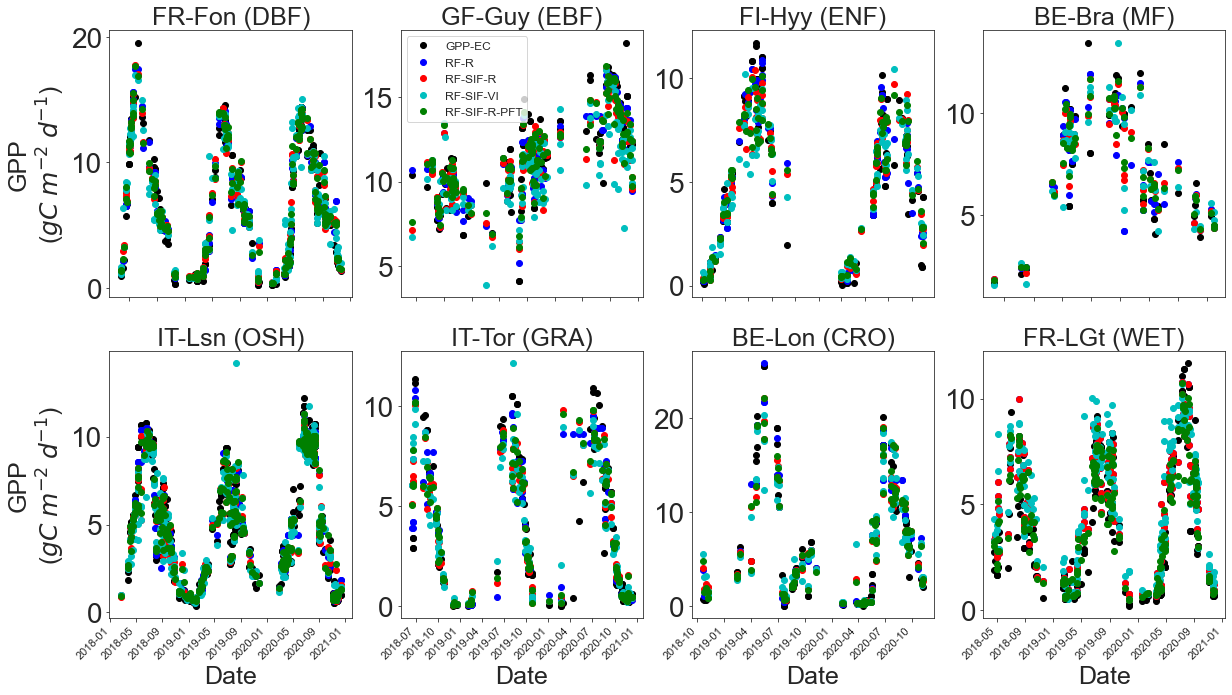

In [36]:
#########################################################################################

data_test.sort_values('Site_name', inplace =True)
list_Sites = data_test["Site_name"].unique().tolist()
# Sorting your biome list

list_Sites = sorted(list_Sites)
print(list_Sites)

#########################################################################################################################
BE_Bra = data_test[(data_test['Site_name']=='BE-Bra')]; BE_Lcr = data_test[(data_test['Site_name']=='BE-Lcr')];
BE_Lon = data_test[(data_test['Site_name']=='BE-Lon')]; BE_Vie = data_test[(data_test['Site_name']=='BE-Vie')];
CH_Dav = data_test[(data_test['Site_name']=='CH-Dav')]; CZ_BK1 = data_test[(data_test['Site_name']=='CZ-BK1')];
CZ_Lnz = data_test[(data_test['Site_name']=='CZ-Lnz')]; CZ_Wet = data_test[(data_test['Site_name']=='CZ-Wet')];
DE_Geb = data_test[(data_test['Site_name']=='DE-Geb')]; DE_Gri = data_test[(data_test['Site_name']=='DE-Gri')];
DE_Hai = data_test[(data_test['Site_name']=='DE-Hai')]; DE_HoH = data_test[(data_test['Site_name']=='DE-HoH')];
DE_Hzd = data_test[(data_test['Site_name']=='DE-Hzd')]; DE_Kli = data_test[(data_test['Site_name']=='DE-Kli')];
DE_RuR = data_test[(data_test['Site_name']=='DE-RuR')]; DE_RuS = data_test[(data_test['Site_name']=='DE-RuS')];
DE_RuW = data_test[(data_test['Site_name']=='DE-RuW')]; DE_Tha = data_test[(data_test['Site_name']=='DE-Tha')];
DK_Sor = data_test[(data_test['Site_name']=='DK-Sor')]; FI_Hyy = data_test[(data_test['Site_name']=='FI-Hyy')];
FI_Sii = data_test[(data_test['Site_name']=='FI-Sii')]; FI_Var = data_test[(data_test['Site_name']=='FI-Var')];
FR_Aur = data_test[(data_test['Site_name']=='FR-Aur')]; FR_Bil = data_test[(data_test['Site_name']=='FR-Bil')];
FR_EM2 = data_test[(data_test['Site_name']=='FR-EM2')]; FR_Fon = data_test[(data_test['Site_name']=='FR-Fon')];
FR_Hes = data_test[(data_test['Site_name']=='FR-Hes')]; FR_LGt = data_test[(data_test['Site_name']=='FR-LGt')];
FR_Mej = data_test[(data_test['Site_name']=='FR-Mej')]; GF_Guy = data_test[(data_test['Site_name']=='GF-Guy')];
IT_BCi = data_test[(data_test['Site_name']=='IT-BCi')]; IT_Cp2 = data_test[(data_test['Site_name']=='IT-Cp2')];
IT_Lsn = data_test[(data_test['Site_name']=='IT-Lsn')]; IT_SR2 = data_test[(data_test['Site_name']=='IT-SR2')];
IT_Tor = data_test[(data_test['Site_name']=='IT-Tor')]; NL_Loo = data_test[(data_test['Site_name']=='NL-Loo')];
SE_Deg = data_test[(data_test['Site_name']=='SE-Deg')]; SE_Htm = data_test[(data_test['Site_name']=='SE-Htm')];
SE_Nor = data_test[(data_test['Site_name']=='SE-Nor')]; SE_Svb = data_test[(data_test['Site_name']=='SE-Svb')];


#################################################################################################################################
#generate example of plots for seasonal and interannual dynamics of observed GPP vs RF model predicted GPP

sns.set_style("ticks")
plt.rc('legend', fontsize=12) #fontsize of the legend
plt.rc('xtick', labelsize= 11) #fontsize of the x tick labels

fig, axes = plt.subplots(2, 4, figsize=(20, 12))

axes[0, 0].plot(FR_Fon['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 0].plot(FR_Fon['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 0].plot(FR_Fon['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 0].plot(FR_Fon['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 0].plot(FR_Fon['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 0].set(xlabel='Year', ylabel='GPP\n($gC$ $m$$^{-2}$ $d$$^{-1}$)')
axes[0, 0].set(title='FR-Fon (DBF)')

axes[0, 1].plot(GF_Guy['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 1].plot(GF_Guy['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 1].plot(GF_Guy['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 1].plot(GF_Guy['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 1].plot(GF_Guy['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 1].set(title='GF-Guy (EBF)')
axes[0, 1].legend(loc='upper left')

axes[0, 2].plot(FI_Hyy['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 2].plot(FI_Hyy['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 2].plot(FI_Hyy['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 2].plot(FI_Hyy['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 2].plot(FI_Hyy['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 2].set(title='FI-Hyy (ENF)')

axes[0, 3].plot(BE_Bra['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 3].plot(BE_Bra['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 3].plot(BE_Bra['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 3].plot(BE_Bra['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 3].plot(BE_Bra['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 3].set(xlabel='Date')
axes[0, 3].set(title='BE-Bra (MF)')

axes[1, 0].plot(IT_Lsn['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 0].plot(IT_Lsn['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 0].plot(IT_Lsn['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 0].plot(IT_Lsn['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 0].plot(IT_Lsn['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[1, 0].set(xlabel='Date')
axes[1, 0].set(title='IT-Lsn (OSH)')
axes[1, 0].set(xlabel='Date', ylabel='GPP\n($gC$ $m$$^{-2}$ $d$$^{-1}$)')

axes[1, 1].plot(IT_Tor['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 1].plot(IT_Tor['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 1].plot(IT_Tor['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 1].plot(IT_Tor['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 1].plot(IT_Tor['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 1].set(xlabel='Date')
axes[1, 1].set(title='IT-Tor (GRA)')

axes[1, 2].plot(BE_Lon['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 2].plot(BE_Lon['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 2].plot(BE_Lon['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 2].plot(BE_Lon['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 2].plot(BE_Lon['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 2].set(xlabel='Date')
axes[1, 2].set(title='BE-Lon (CRO)')

axes[1, 3].plot(FR_LGt['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 3].plot(FR_LGt['GPP_RF_SIF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 3].plot(FR_LGt['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 3].plot(FR_LGt['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 3].plot(FR_LGt['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 3].set(title='FR-LGt (WET)')
axes[1, 3].set(xlabel='Date')

fig.autofmt_xdate(rotation=45)

#fig.savefig('RF_Sites1.svg', dpi = 500) # uncomment this line to record your figure into your working directory


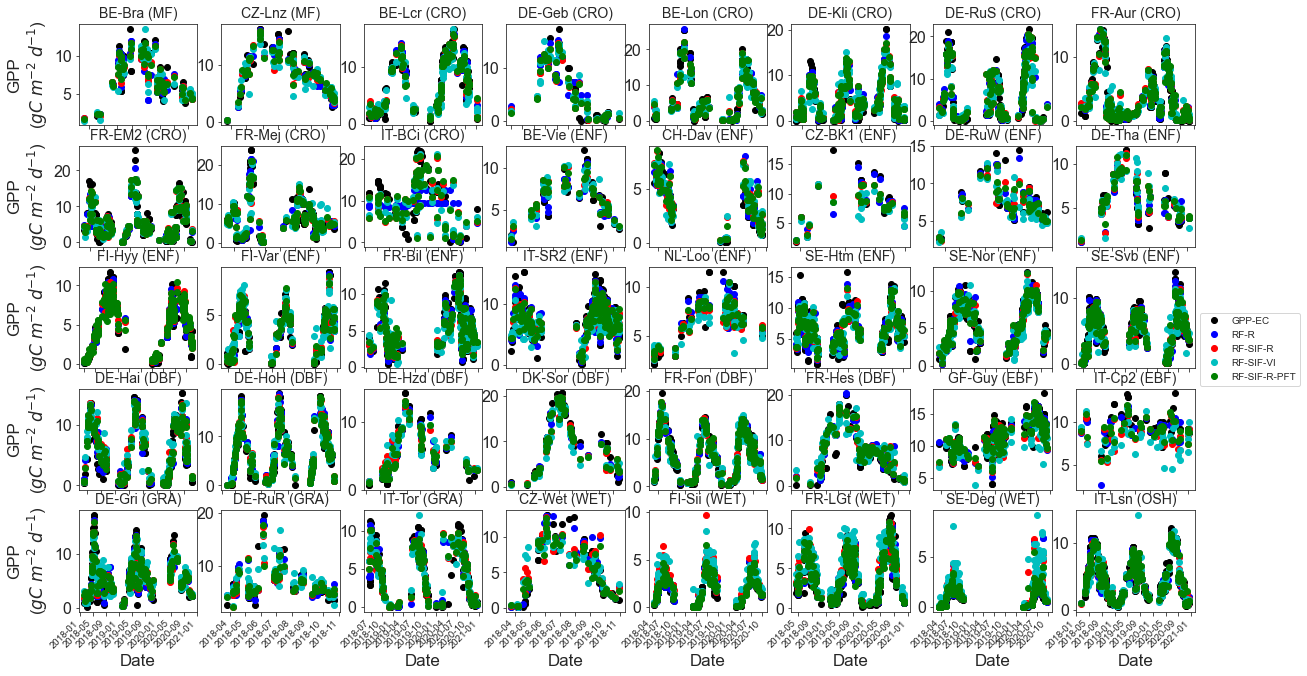

In [38]:
#generate plots for seasonal and interannual dynamics of observed GPP vs RF model predicted GPP for each site

sns.set_style("ticks")
plt.rc('xtick', labelsize= 9.5) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=10) #fontsize of the legend
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=17) #fontsize of the x and y labels

fig, axes = plt.subplots(5, 8, figsize=(20, 12))

axes[0, 0].plot(BE_Bra['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 0].plot(BE_Bra['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 0].plot(BE_Bra['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 0].plot(BE_Bra['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 0].plot(BE_Bra['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 0].set(xlabel='Year', ylabel='GPP\n($gC$ $m$$^{-2}$ $d$$^{-1}$)')
axes[0, 0].set(title='BE-Bra (MF)')

axes[0, 1].plot(CZ_Lnz['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 1].plot(CZ_Lnz['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 1].plot(CZ_Lnz['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 1].plot(CZ_Lnz['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 1].plot(CZ_Lnz['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[0, 1].set(title='CZ-Lnz (MF)')
#axes[0, 1].legend(loc='upper left')

axes[0, 2].plot(BE_Lcr['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 2].plot(BE_Lcr['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 2].plot(BE_Lcr['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 2].plot(BE_Lcr['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 2].plot(BE_Lcr['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 2].set(title='BE-Lcr (CRO)')

axes[0, 3].plot(DE_Geb['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 3].plot(DE_Geb['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 3].plot(DE_Geb['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 3].plot(DE_Geb['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 3].plot(DE_Geb['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 3].set(title='DE-Geb (CRO)')

axes[0, 4].plot(BE_Lon['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 4].plot(BE_Lon['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 4].plot(BE_Lon['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 4].plot(BE_Lon['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 4].plot(BE_Lon['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 4].set(xlabel='Date')
axes[0, 4].set(title='BE-Lon (CRO)')
axes[0, 4].set(xlabel='Date')

axes[0, 5].plot(DE_Kli['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 5].plot(DE_Kli['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 5].plot(DE_Kli['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 5].plot(DE_Kli['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 5].plot(DE_Kli['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 5].set(xlabel='Date')
axes[0, 5].set(title='DE-Kli (CRO)')

axes[0, 6].plot(DE_RuS['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 6].plot(DE_RuS['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 6].plot(DE_RuS['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 6].plot(DE_RuS['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 6].plot(DE_RuS['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[0, 6].set(xlabel='Date')
axes[0, 6].set(title='DE-RuS (CRO)')

axes[0, 7].plot(FR_Aur['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[0, 7].plot(FR_Aur['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[0, 7].plot(FR_Aur['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[0, 7].plot(FR_Aur['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[0, 7].plot(FR_Aur['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[0, 7].set(xlabel='Date')
axes[0, 7].set(title='FR-Aur (CRO)')

##################################################################################################################""
axes[1, 0].plot(FR_EM2['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 0].plot(FR_EM2['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 0].plot(FR_EM2['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 0].plot(FR_EM2['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 0].plot(FR_EM2['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 0].set(title='FR-EM2 (CRO)')
axes[1, 0].set(xlabel='Date', ylabel='GPP\n($gC$ $m$$^{-2}$ $d$$^{-1}$)')

axes[1, 1].plot(FR_Mej['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 1].plot(FR_Mej['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 1].plot(FR_Mej['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 1].plot(FR_Mej['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 1].plot(FR_Mej['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 1].set(title='FR-Mej (CRO)')

axes[1, 2].plot(IT_BCi['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 2].plot(IT_BCi['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 2].plot(IT_BCi['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 2].plot(IT_BCi['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 2].plot(IT_BCi['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 2].set(title='IT-BCi (CRO)')
#axes[0, 1].legend(loc='upper left')


axes[1, 3].plot(BE_Vie['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 3].plot(BE_Vie['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 3].plot(BE_Vie['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 3].plot(BE_Vie['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 3].plot(BE_Vie['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 3].set(title='BE-Vie (ENF)')

axes[1, 4].plot(CH_Dav['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 4].plot(CH_Dav['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 4].plot(CH_Dav['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 4].plot(CH_Dav['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 4].plot(CH_Dav['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 4].set(title='CH-Dav (ENF)')

axes[1, 5].plot(CZ_BK1['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 5].plot(CZ_BK1['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 5].plot(CZ_BK1['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 5].plot(CZ_BK1['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 5].plot(CZ_BK1['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 5].set(xlabel='Date')
axes[1, 5].set(title='CZ-BK1 (ENF)')
axes[1, 5].set(xlabel='Date')

axes[1, 6].plot(DE_RuW['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 6].plot(DE_RuW['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 6].plot(DE_RuW['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 6].plot(DE_RuW['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 6].plot(DE_RuW['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 6].set(xlabel='Date')
axes[1, 6].set(title='DE-RuW (ENF)')

axes[1, 7].plot(DE_Tha['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[1, 7].plot(DE_Tha['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[1, 7].plot(DE_Tha['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[1, 7].plot(DE_Tha['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[1, 7].plot(DE_Tha['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[1, 7].set(xlabel='Date')
axes[1, 7].set(title='DE-Tha (ENF)')

axes[2, 0].plot(FI_Hyy['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[2, 0].plot(FI_Hyy['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[2, 0].plot(FI_Hyy['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[2, 0].plot(FI_Hyy['GPP_RF_SIF_VI'], '.g', label = 'RF-SIF-VI', marker ='o')
axes[2, 0].plot(FI_Hyy['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[2, 0].set(xlabel='Date')
axes[2, 0].set(title='FI-Hyy (ENF)')
axes[2, 0].set(xlabel='Date', ylabel='GPP\n($gC$ $m$$^{-2}$ $d$$^{-1}$)')

fig.autofmt_xdate(rotation=45)

##################################################################################################################""

axes[2, 1].plot(FI_Var['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[2, 1].plot(FI_Var['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[2, 1].plot(FI_Var['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[2, 1].plot(FI_Var['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[2, 1].plot(FI_Var['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[2, 1].set(title='FI-Var (ENF)')

axes[2, 2].plot(FR_Bil['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[2, 2].plot(FR_Bil['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[2, 2].plot(FR_Bil['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[2, 2].plot(FR_Bil['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[2, 2].plot(FR_Bil['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[2, 2].set(title='FR-Bil (ENF)')
#axes[0, 1].legend(loc='upper left')

axes[2, 3].plot(IT_SR2['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[2, 3].plot(IT_SR2['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[2, 3].plot(IT_SR2['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[2, 3].plot(IT_SR2['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[2, 3].plot(IT_SR2['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[2, 3].set(title='IT-SR2 (ENF)')
axes[2, 4].plot(NL_Loo['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[2, 4].plot(NL_Loo['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[2, 4].plot(NL_Loo['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[2, 4].plot(NL_Loo['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[2, 4].plot(NL_Loo['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[2, 4].set(title='NL-Loo (ENF)')

axes[2, 5].plot(SE_Htm['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[2, 5].plot(SE_Htm['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[2, 5].plot(SE_Htm['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[2, 5].plot(SE_Htm['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[2, 5].plot(SE_Htm['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[2, 5].set(xlabel='Date')
axes[2, 5].set(title='SE-Htm (ENF)')
axes[2, 5].set(xlabel='Date')

axes[2, 6].plot(SE_Nor['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[2, 6].plot(SE_Nor['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[2, 6].plot(SE_Nor['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[2, 6].plot(SE_Nor['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[2, 6].plot(SE_Nor['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[2, 6].set(xlabel='Date')
axes[2, 6].set(title='SE-Nor (ENF)')

axes[2, 7].plot(SE_Svb['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[2, 7].plot(SE_Svb['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[2, 7].plot(SE_Svb['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[2, 7].plot(SE_Svb['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[2, 7].plot(SE_Svb['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[2, 7].set(xlabel='Date')
axes[2, 7].set(title='SE-Svb (ENF)')


fig.autofmt_xdate(rotation=45)

##################################################################################################################""
axes[3, 0].plot(DE_Hai['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[3, 0].plot(DE_Hai['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[3, 0].plot(DE_Hai['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[3, 0].plot(DE_Hai['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[3, 0].plot(DE_Hai['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[3, 0].set(xlabel='Date')
axes[3, 0].set(title='DE-Hai (DBF)')
axes[3, 0].set(xlabel='Date', ylabel='GPP\n($gC$ $m$$^{-2}$ $d$$^{-1}$)')

axes[3, 1].plot(DE_HoH['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[3, 1].plot(DE_HoH['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[3, 1].plot(DE_HoH['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[3, 1].plot(DE_HoH['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[3, 1].plot(DE_HoH['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[3, 1].set(title='DE-HoH (DBF)')

axes[3, 2].plot(DE_Hzd['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[3, 2].plot(DE_Hzd['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[3, 2].plot(DE_Hzd['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[3, 2].plot(DE_Hzd['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[3, 2].plot(DE_Hzd['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[3, 2].set(title='DE-Hzd (DBF)')
#axes[0, 1].legend(loc='upper left')

axes[3, 3].plot(DK_Sor['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[3, 3].plot(DK_Sor['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[3, 3].plot(DK_Sor['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[3, 3].plot(DK_Sor['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[3, 3].plot(DK_Sor['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[3, 3].set(title='DK-Sor (DBF)')

axes[3, 4].plot(FR_Fon['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[3, 4].plot(FR_Fon['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[3, 4].plot(FR_Fon['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[3, 4].plot(FR_Fon['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[3, 4].plot(FR_Fon['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[3, 4].set(title='FR-Fon (DBF)')

axes[3, 5].plot(FR_Hes['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[3, 5].plot(FR_Hes['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[3, 5].plot(FR_Hes['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[3, 5].plot(FR_Hes['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[3, 5].plot(FR_Hes['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[3, 5].set(xlabel='Date')
axes[3, 5].set(title='FR-Hes (DBF)')
axes[3, 5].set(xlabel='Date')

axes[3, 6].plot(GF_Guy['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[3, 6].plot(GF_Guy['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[3, 6].plot(GF_Guy['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[3, 6].plot(GF_Guy['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[3, 6].plot(GF_Guy['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[3, 6].set(xlabel='Date')
axes[3, 6].set(title='GF-Guy (EBF)')

axes[3, 7].plot(IT_Cp2['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[3, 7].plot(IT_Cp2['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[3, 7].plot(IT_Cp2['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[3, 7].plot(IT_Cp2['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[3, 7].plot(IT_Cp2['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[3, 7].set(xlabel='Date')
axes[3, 7].set(title='IT-Cp2 (EBF)')

fig.autofmt_xdate(rotation=45)

##################################################################################################################""
axes[4, 0].plot(DE_Gri['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[4, 0].plot(DE_Gri['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[4, 0].plot(DE_Gri['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[4, 0].plot(DE_Gri['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[4, 0].plot(DE_Gri['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[4, 0].set(xlabel='Date')
axes[4, 0].set(title='DE-Gri (GRA)')
axes[4, 0].set(xlabel='Date', ylabel='GPP\n($gC$ $m$$^{-2}$ $d$$^{-1}$)')


axes[4, 1].plot(DE_RuR['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[4, 1].plot(DE_RuR['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[4, 1].plot(DE_RuR['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[4, 1].plot(DE_RuR['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[4, 1].plot(DE_RuR['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[4, 1].set(title='DE-RuR (GRA)')

axes[4, 2].plot(IT_Tor['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[4, 2].plot(IT_Tor['GPP_RF_R'], '.b', label = 'GPP-RF-R', marker ='o') 
axes[4, 2].plot(IT_Tor['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[4, 2].plot(IT_Tor['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[4, 2].plot(IT_Tor['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[4, 2].set(title='IT-Tor (GRA)')
axes[4, 2].set(xlabel='Date')

#axes[0, 1].legend(loc='upper left')

axes[4, 3].plot(CZ_Wet['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[4, 3].plot(CZ_Wet['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[4, 3].plot(CZ_Wet['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[4, 3].plot(CZ_Wet['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[4, 3].plot(CZ_Wet['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[4, 3].set(title='CZ-Wet (WET)')
axes[4, 3].set(xlabel='Date')

axes[4, 4].plot(FI_Sii['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[4, 4].plot(FI_Sii['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[4, 4].plot(FI_Sii['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[4, 4].plot(FI_Sii['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[4, 4].plot(FI_Sii['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[4, 4].set(title='FI-Sii (WET)')
axes[4, 4].set(xlabel='Date')

axes[4, 5].plot(FR_LGt['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[4, 5].plot(FR_LGt['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[4, 5].plot(FR_LGt['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[4, 5].plot(FR_LGt['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[4, 5].plot(FR_LGt['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[4, 5].set(xlabel='Date')
axes[4, 5].set(title='FR-LGt (WET)')
axes[4, 5].set(xlabel='Date')

axes[4, 6].plot(SE_Deg['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[4, 6].plot(SE_Deg['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[4, 6].plot(SE_Deg['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[4, 6].plot(SE_Deg['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[4, 6].plot(SE_Deg['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')

axes[4, 6].set(xlabel='Date')
axes[4, 6].set(title='SE-Deg (WET)')

axes[4, 7].plot(IT_Lsn['GPP'],'.k', label = 'GPP-EC', marker ='o')
axes[4, 7].plot(IT_Lsn['GPP_RF_R'], '.b', label = 'RF-R', marker ='o') 
axes[4, 7].plot(IT_Lsn['GPP_RF_SIF_R'], '.r', label = 'RF-SIF-R', marker ='o')
axes[4, 7].plot(IT_Lsn['GPP_RF_SIF_VI'], '.c', label = 'RF-SIF-VI', marker ='o')
axes[4, 7].plot(IT_Lsn['GPP_RF_SIF_IGBP'], '.g', label = 'RF-SIF-R-PFT', marker ='o')
axes[4, 7].set(xlabel='Date')
axes[4, 7].set(title='IT-Lsn (OSH)')
fig.autofmt_xdate(rotation=45)

plt.legend(bbox_to_anchor=(1,3), loc="upper left")
#fig.savefig('RF_Random_All_sites1.svg', dpi =500) uncomment this line to save your figure into your working directory


In [41]:
##########################################################################################################
# load feature relative importance for each model

Dat = pd.read_csv('D:\SIF_GPP_PRI_Tropomi\Linear_Regression_output\LR_Stats/RF_R2_Importances.csv')

#Dat.rename(columns ={'PRI13':'PRI', 'IGBP_LCnum':'IGBP_Biome'})

Dat['Variables'] = Dat["Variables"].replace({'PRI13':'PRI','IGBP_LCnum':'$PFT$',
                  'SIF_Daily':'$SIF_d$', 'B1':'$B1_(645nm)$','B2':'$B2_(858nm)$','B3':'$B3_(469nm)$',
                 'B4':'$B4_(555nm)$','B5':'$B5_(1240nm)$','B6':'$B6_(1640nm)$','B7':'$B7_(2130nm)$',
                 'B8':'$B8_(412nm)$','B9':'$B9_(465nm)$','B11':'$B11_(531nm)$','B13':'$B13_(667nm)$'})
Dat.drop(columns =['Unnamed: 0'], inplace = True)

Dat
#################################################################################################################################
Dat2 = pd.read_csv('D:\SIF_GPP_PRI_Tropomi\Linear_Regression_output\LR_Stats/RF_SIF_R2_Importances.csv')

#Dat.rename(columns ={'PRI13':'PRI', 'IGBP_LCnum':'IGBP_Biome'})

Dat2['Variables'] = Dat2["Variables"].replace({'PRI13':'PRI','IGBP_LCnum':'$PFT$',
                  'SIF Daily':'$SIF_d$', 'B1':'$B1_(645nm)$','B2':'$B2_(858nm)$','B3':'$B3_(469nm)$',
                 'B4':'$B4_(555nm)$','B5':'$B5_(1240nm)$','B6':'$B6_(1640nm)$','B7':'$B7_(2130nm)$',
                 'B8':'$B8_(412nm)$','B9':'$B9_(465nm)$','B11':'$B11_(531nm)$','B13':'$B13_(667nm)$'})
Dat2.drop(columns =['Unnamed: 0'], inplace = True)

Dat2
######################################################################################################################
Dat3 = pd.read_csv('D:\SIF_GPP_PRI_Tropomi\Linear_Regression_output\LR_Stats/RF_SIF_VI2_Importances.csv')

#Dat.rename(columns ={'PRI13':'PRI', 'IGBP_LCnum':'IGBP_Biome'})

Dat3['Variables'] = Dat3["Variables"].replace({'PRI13':'PRI','IGBP_LCnum':'$PFT$',
                  'SIF Daily':'$SIF_d$', 'B1':'$B1_(645nm)$','B2':'$B2_(858nm)$','B3':'$B3_(469nm)$',
                 'B4':'$B4_(555nm)$','B5':'$B5_(1240nm)$','B6':'$B6_(1640nm)$','B7':'$B7_(2130nm)$',
                 'B8':'$B8_(412nm)$','B9':'$B9_(465nm)$','B11':'$B11_(531nm)$','B13':'$B13_(667nm)$'})
Dat3.drop(columns =['Unnamed: 0'], inplace = True)
######################################################################################################################
Dat4 = pd.read_csv('D:\SIF_GPP_PRI_Tropomi\Linear_Regression_output\LR_Stats/RF_SIF_IGBP2_Importances.csv')

Dat4['Variables'] = Dat4["Variables"].replace({'PRI13':'PRI','IGBP_site':'$PFT$',
                  'SIF Daily':'$SIF_d$', 'B1':'$B1_(645nm)$','B2':'$B2_(858nm)$','B3':'$B3_(469nm)$',
                 'B4':'$B4_(555nm)$','B5':'$B5_(1240nm)$','B6':'$B6_(1640nm)$','B7':'$B7_(2130nm)$',
                 'B8':'$B8_(412nm)$','B9':'$B9_(465nm)$','B11':'$B11_(531nm)$','B13':'$B13_(667nm)$'})
Dat4.drop(columns =['Unnamed: 0'], inplace = True)
Dat4


Variables  Importances  MeanPermutation  StdPermutation
0    $B8_(412nm)$     0.037224         0.029170        0.001392
1    $B9_(465nm)$     0.043661         0.039082        0.001080
2   $B11_(531nm)$     0.043842         0.041601        0.001172
3    $B4_(555nm)$     0.047111         0.055214        0.002233
4    $B3_(469nm)$     0.049730         0.051391        0.001582
5   $B7_(2130nm)$     0.055816         0.064534        0.001656
6   $B6_(1640nm)$     0.058644         0.084214        0.001553
7   $B5_(1240nm)$     0.058937         0.062306        0.001577
8           $PFT$     0.060355         0.106852        0.003713
9   $B13_(667nm)$     0.068418         0.090283        0.002709
10   $B1_(645nm)$     0.088032         0.235468        0.003054
11   $B2_(858nm)$     0.162689         0.358704        0.006767
12        $SIF_d$     0.225540         0.224748        0.008020

(0.0, 0.25)

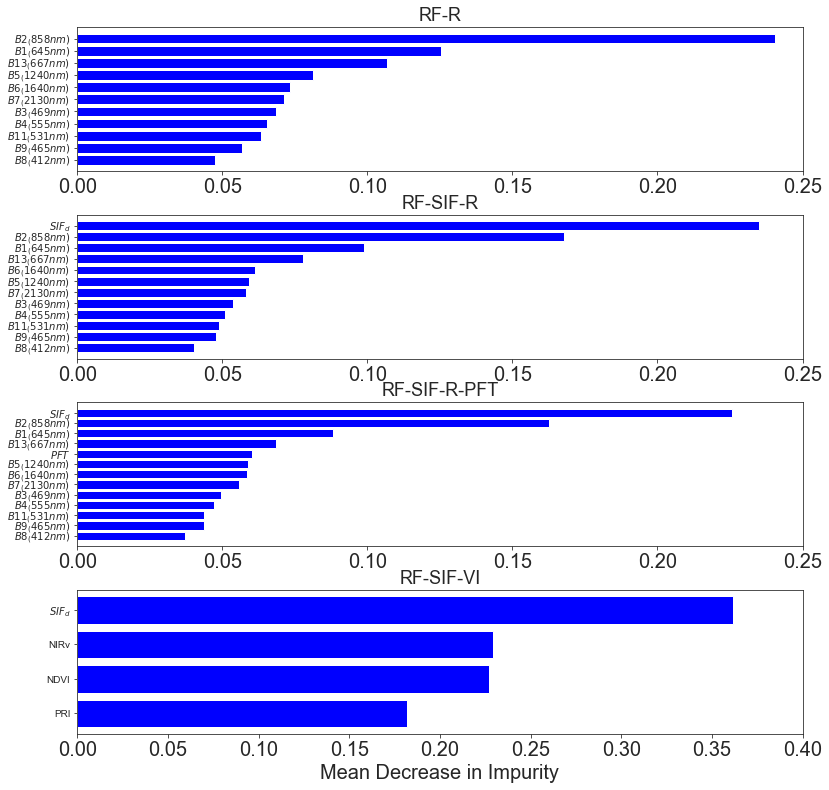

In [42]:
# Generate the feature relative importance plot for all models

plt.rc('axes', titlesize=18) #fontsize of the title
plt.rc('axes', labelsize= 20) #fontsize of the x and y labels
plt.rc('ytick', labelsize=12) #fontsize of the y tick labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
sns.set_style("ticks")

################################################################################################

plt.rc('ytick', labelsize=10) #fontsize of the y tick labels

fig, axs = plt.subplots(4, figsize=(13, 13), gridspec_kw={ 'hspace': 0.3,'wspace': 0.3})
#fig.suptitle('Vertically stacked subplots')
axs[0].barh( Dat['Variables'], Dat['Importances'], color='b', align='center')
axs[1].barh(Dat2['Variables'], Dat2['Importances'], color='b', align='center')
axs[2].barh(Dat4['Variables'], Dat4['Importances'], color='b', align='center')
axs[3].barh(Dat3['Variables'], Dat3['Importances'], color='b', align='center')
#axs[0].set(ylabel ='Features')
axs[0].set(title ='RF-R')
axs[1].set(title ='RF-SIF-R')
axs[3].set(title ='RF-SIF-VI')
axs[2].set(title ='RF-SIF-R-PFT')
axs[3].set(xlabel ='Mean Decrease in Impurity')

axs[0].set_xlim(0,0.25)
axs[1].set_xlim(0,0.25)
axs[3].set_xlim(0,0.40)
axs[2].set_xlim(0,0.25)
#fig.savefig('RF_model_import3.svg', dpi = 500) # uncomment this line to save your figure into your working directory